## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [94]:
# imports
import os
import sys
import torch
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm
import scipy as sp
from scipy import integrate



module_path = os.path.abspath(os.path.join('../../multiscale_HiTS/src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
import ResNet as tnet

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net
from utils_MrCAE import *


## Simulation 

  0%|          | 0/500 [00:00<?, ?it/s]

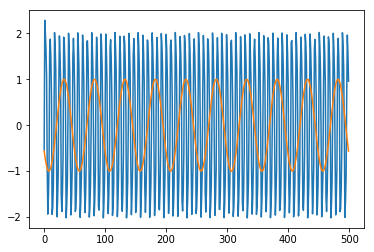

NameError: name 'hj' is not defined

In [27]:
#make amd save data
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

dt = 1.0



# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t_evolve):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*t_evolve[:,1]

mu = 2.0
def van_der_pol_rhs(x):
    return np.array([x[1], mu*(1-x[0]**2)*x[1]-x[0]])


# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
total_steps = 500
t = np.linspace(0, 40*np.pi, total_steps)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)


# Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
# print(Phi.shape)
# plt.plot(Phi[0,0])


# generate data shape (100,500,127,127)
n_train = 500
n_val = 100
train_data = np.zeros((n_train,total_steps,127,127))
for i in tqdm(range(n_train)):
    #t start somewhere between zero and 2 pi
    start_t = np.random.rand(1) * 2*np.pi
#     print(start_t)
    t = np.linspace(0, 40*np.pi, total_steps) + start_t
    xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
    
    t_van_der_pol = np.linspace(0, (total_steps)*dt, total_steps)
    x_init = [np.random.uniform(-2.0, 2.0), np.random.uniform(-4.0, 4.0)]
    sol = sp.integrate.solve_ivp(lambda _, x: van_der_pol_rhs(x), [0, total_steps*dt], x_init, t_eval=t_van_der_pol)
    
    plt.plot(sol.y.T[:,0])
    plt.plot(np.cos(w0*t))
    plt.show()
    hj

    Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, sol.y.T)
    scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
    train_data[i] = scaled_Phi.T
    

    
# print("saving...")
# #normalize 
# train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
# np.save('../data/toy2_train_data.npy',train_data)


n_train = 500
n_val = 100
val_data = np.zeros((n_train,total_steps,127,127))
for i in tqdm(range(n_val)):
    #t start somewhere between zero and 2 pi
    start_t = np.random.rand(1) * 2*np.pi
#     print(start_t)
    t = np.linspace(0, 40*np.pi, total_steps) + start_t
    xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
    
    t_van_der_pol = np.linspace(0, (total_steps)*dt, total_steps)
    x_init = [np.random.uniform(-2.0, 2.0), np.random.uniform(-4.0, 4.0)]
    sol = sp.integrate.solve_ivp(lambda _, x: van_der_pol_rhs(x), [0, total_steps*dt], x_init, t_eval=t_van_der_pol)
    
#     plt.plot(sol.y[1]/10)
#     plt.plot(np.cos(w0*t))
#     plt.show()
    Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, sol.y.T)
    scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
    val_data[i] = scaled_Phi.T

# val_data = np.zeros((n_val,total_steps,127,127))
# for i in tqdm(range(n_val)):
#     #t start somewhere between zero and 2 pi
#     start_t = np.random.rand(1) * 2*np.pi
#     t = np.linspace(0, 40*np.pi, total_steps) + start_t
#     xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
#     Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
#     scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
#     val_data[i] = scaled_Phi.T
    
print("saving ...")
#normalize 
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
np.save('../data/toy2_val_data.npy',val_data)

## MrCAE

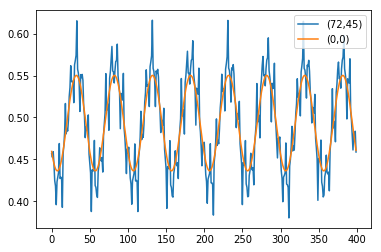

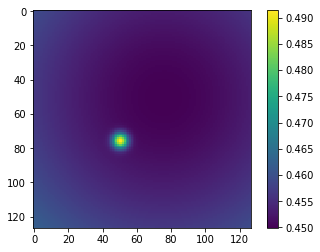

In [95]:
#load data

train_data = np.load('../data/toy2_train_data.npy')
val_data = np.load('../data/toy2_val_data.npy')

train_data = train_data[:,100:]
val_data = val_data[:,100:]
# plt.plot(train_data[0,:,0,0])
# plt.plot(val_data[0,:,0,0])

plt.plot(train_data[0,:,72,45], label ='(72,45)')
plt.plot(train_data[0,:,0,0], label = '(0,0)')
plt.legend()

# plt.plot(val_data[0,:,72,45])
plt.show()
plt.imshow(train_data[0,0])
plt.colorbar()

In [13]:
print(train_data.shape)

(500, 500, 127, 127)


Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [124]:
# init model & load data
# print(train_data.shape)
data_path = '../data/toy2.npy'
# np.save(data_path, train_data[:,0])
# data_path = '../data/toy1_train_data.npy'
model_path = '../model/toy2_space/'
result_path = '../result/toy2_space/' 

# data = np.load(data_path)
# print(data.shape)

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

torch.Size([350, 1, 31, 31])


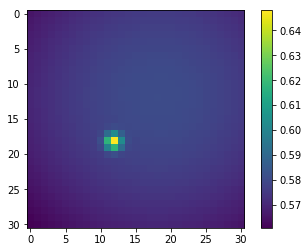

torch.Size([350, 1, 63, 63])


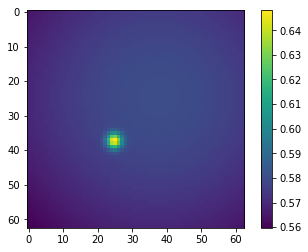

torch.Size([350, 1, 127, 127])


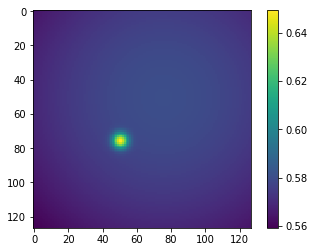

In [5]:
# train_data, _,_ = dataset.obtain_data_at_current_level(0)

# print(train_data.shape)
# plt.imshow(train_data[0,0].cpu().detach().numpy())#, vmin = 0.3, vmax=0.6)
# plt.colorbar()
# plt.show()

# train_data, _,_ = dataset.obtain_data_at_current_level(1)

# print(train_data.shape)
# plt.imshow(train_data[0,0].cpu().detach().numpy())#, vmin = 0.3, vmax=0.6)
# plt.colorbar()
# plt.show()

# train_data, _,_ = dataset.obtain_data_at_current_level(2)

# print(train_data.shape)
# plt.imshow(train_data[0,0].cpu().detach().numpy())#, vmin = 0.3, vmax=0.6)
# plt.colorbar()

In [7]:
# print(dataset.train_data.shape)

In [125]:
# training in space
archs = [[1,2],[1,2],[1,3]]#,3,4],[1,2,3,4],[1,3,5,7]]
tols = [ 0.001, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)

*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/2000]
[training set] local: 0.0020/0.0232/0.0126, global: 0.0020/0.0232/0.0126
[validation set] local: 0.0020/0.0265/0.0142, global: 0.0019/0.0265/0.0142
epoch [200/2000]:
[training set] local: 0.0005/0.0165/0.0085, global: 0.0005/0.0165/0.0085
[validation set] local: 0.0005/0.0182/0.0093, global: 0.0004/0.0182/0.0093
epoch [400/2000]:
[training set] local: 0.0012/0.0083/0.0047, global: 0.0011/0.0089/0.0050
[validation set] local: 0.0011/0.0090/0.0051, global: 0.0011/0.0097/0.0054
epoch [600/2000]:
[training set] local: 0.0005/0.0050/0.0028, global: 0.0005/0.0072/0.0039
[validation set] local: 0.0005/0.0055/0.0030, global: 0.0005/0.0079/0.0042
epoch [800/2000]:
[training set] local: 0.0002/0.0031/0.0016, global: 0.0002/0.0063/

epoch [600/2000]:
[training set] local: 0.0000/0.0006/0.0003, global: 0.0000/0.0007/0.0004
[validation set] local: 0.0000/0.0006/0.0003, global: 0.0000/0.0008/0.0004
epoch [800/2000]:
[training set] local: 0.0000/0.0005/0.0003, global: 0.0000/0.0007/0.0003
[validation set] local: 0.0000/0.0006/0.0003, global: 0.0000/0.0007/0.0004
epoch [1000/2000]:
[training set] local: 0.0000/0.0005/0.0003, global: 0.0000/0.0006/0.0003
[validation set] local: 0.0000/0.0006/0.0003, global: 0.0000/0.0007/0.0004
epoch [1200/2000]:
[training set] local: 0.0000/0.0005/0.0003, global: 0.0000/0.0006/0.0003
[validation set] local: 0.0000/0.0006/0.0003, global: 0.0000/0.0007/0.0003
epoch [1400/2000]:
[training set] local: 0.0000/0.0005/0.0003, global: 0.0000/0.0006/0.0003
[validation set] local: 0.0000/0.0005/0.0003, global: 0.0000/0.0007/0.0003
epoch [1600/2000]:
[training set] local: 0.0000/0.0005/0.0002, global: 0.0000/0.0006/0.0003
[validation set] local: 0.0000/0.0005/0.0003, global: 0.0000/0.0006/0.0003


epoch [200/2000]:
[training set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
[validation set] local: 0.0000/0.0004/0.0002, global: 0.0000/0.0004/0.0002
epoch [400/2000]:
[training set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
[validation set] local: 0.0000/0.0004/0.0002, global: 0.0000/0.0004/0.0002
epoch [600/2000]:
[training set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
[validation set] local: 0.0000/0.0004/0.0002, global: 0.0000/0.0004/0.0002
epoch [800/2000]:
[training set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
[validation set] local: 0.0000/0.0004/0.0002, global: 0.0000/0.0004/0.0002
epoch [1000/2000]:
[training set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
[validation set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
epoch [1200/2000]:
[training set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
[validation set] local: 0.0000/0.0003/0.0002, global: 0.0000/0.0003/0.0002
ep

CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_Conv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_Conv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_deConv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3

In [126]:
# trained models at different levels
models_space = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models_space[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_0_16
model_L0_0_16_DMD
model_L0_0_16_noise
model_L0_0_1_DMD
model_L0_0_2
model_L0_0_2_DMD
model_L0_0_2_noise
model_L0_0_32_DMD
model_L0_0_4
model_L0_0_4_DMD
model_L0_0_4_noise
model_L0_0_8
model_L0_0_8_DMD
model_L0_0_8_noise
model_L0_1
model_L0_1_1
model_L0_1_2
model_L0_1_4
model_L1_0
model_L1_1
model_L2_0
model_L2_1


(500, 400, 127, 127)
torch.Size([500, 1, 127, 127])
torch.Size([500, 1, 127, 127])


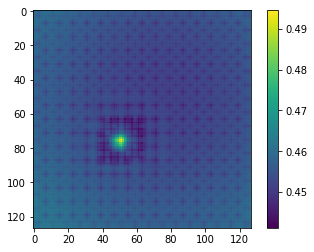

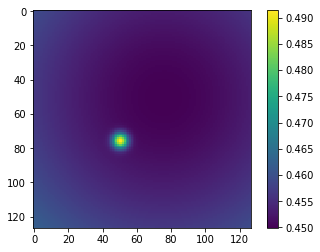

In [141]:
model = models_space['model_L2_1']

print(train_data.shape)
print(torch.tensor(train_data[:,0]).unsqueeze(1).to('cuda').float().shape)
forward_full,_,_,_ = model(torch.tensor(train_data[:,0]).unsqueeze(1).to('cuda').float(), 2)

print(torch.tensor(train_data[:,0]).unsqueeze(1).to('cuda').float().shape)

plt.imshow(forward_full[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()


plt.imshow(train_data[0,0])
plt.colorbar()
plt.show()

In [98]:
#define some functions
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for i in range(n_levels - level - 1):
            data = apply_local_op(data.to(device), device, ave=False)

        return data
    
    
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            return encoded
        #else:
        i = self.n_filter_groups_each_level['0']-1
#         print('L{}_Conv_{}'.format(level, i))
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
            
            
        else:
            i =self.n_filter_groups_each_level['0'] -1
            y = self._modules['L{}_deConv_{}'.format(level, i)](encoded)
            
        return y

train_data shape =  (500, 400, 127, 127)


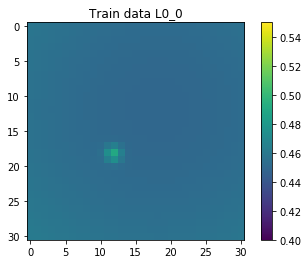

torch.Size([400, 1, 15, 15])


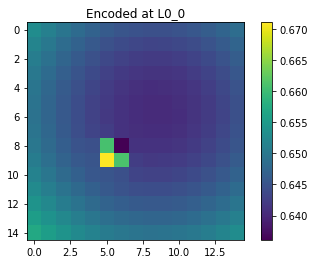

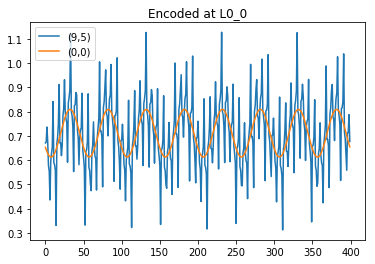

torch.Size([400, 1, 15, 15])


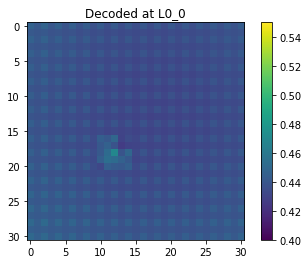

train_data_this =  torch.Size([400, 1, 31, 31])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


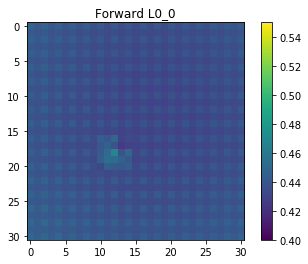

torch.Size([400, 1, 31, 31])


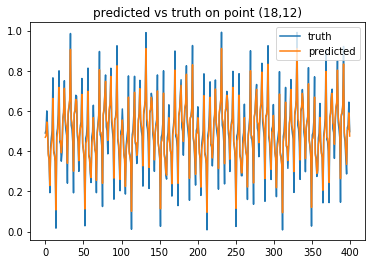

torch.Size([400, 31, 31])


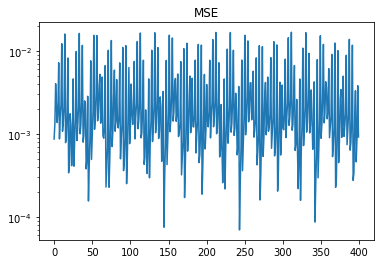

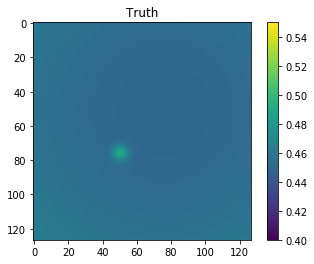

In [121]:
model = models_space['model_L0_0']

vmin=0.4
vmax=0.55

print("train_data shape = ", train_data.shape)
train_data_this = obtain_data_at_current_level(torch.tensor(train_data[0]).unsqueeze(1).float(), 0,3)

plt.imshow(train_data_this[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.title("Train data L0_0")
plt.colorbar()
plt.show()


encoded = encode(model, train_data_this.to('cuda').float(), 0)
print(encoded.shape)
plt.imshow(encoded[0,0].cpu().detach().numpy())
plt.title("Encoded at L0_0")
plt.colorbar()
plt.show()


plt.plot(encoded[:,0,9,5].cpu().detach().numpy(), label = "(9,5)")
plt.plot(encoded[:,0,0,0].cpu().detach().numpy(), label = "(0,0)")
plt.title("Encoded at L0_0")
plt.legend()
plt.show()

print(encoded.shape)
decoded = decode(model, encoded, 0)
plt.imshow(decoded[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Decoded at L0_0")
plt.show()

print("train_data_this = ", train_data_this.shape)
forward,_,_,_ = model(torch.tensor(train_data_this[:,0]).unsqueeze(1).to('cuda').float(), 0)
plt.imshow(forward[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.title("Forward L0_0")
plt.colorbar()
plt.show()

print(forward.shape)
plt.plot(train_data_this[:,0,18,12].cpu().detach().numpy(), label = "truth")
plt.plot(forward[:,0,18,12].cpu().detach().numpy(), label = "predicted")

plt.legend()
plt.title("predicted vs truth on point (18,12)")
plt.show()

print(train_data_this[:,0].shape)
x = train_data_this[:,0].cpu().detach().numpy()
y = forward[:,0].cpu().detach().numpy()
# print(x.shape)
# print(y.shape)
# print((np.mean((x-y)**2, axis = (1,2))))
plt.semilogy(np.max((x-y)**2, axis = (1,2)))
plt.title("MSE")
plt.show()

plt.imshow(train_data[0,0], vmin=vmin, vmax=vmax)
plt.title("Truth")
plt.colorbar()
plt.show()

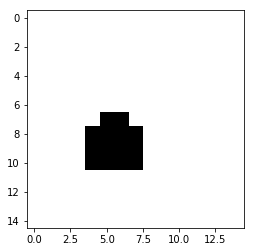

In [85]:
plt.imshow(model.resolved_maps['0']['0'].cpu().detach().numpy(), 'gray')

In [102]:
train_data_this_15 = obtain_data_at_current_level(torch.tensor(train_data[0]).unsqueeze(1).float(), 0,4)
print(train_data_this_15.shape)

torch.Size([400, 1, 15, 15])


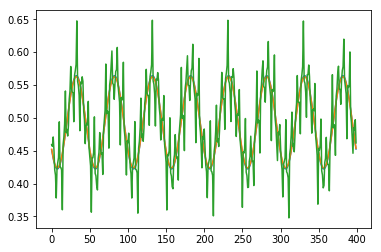

In [107]:
plt.plot(train_data_this_15[:,0,7,5].cpu().detach().numpy())
plt.plot(train_data_this_15[:,0,8,4].cpu().detach().numpy())
plt.plot(train_data_this_15[:,0,8,5].cpu().detach().numpy())

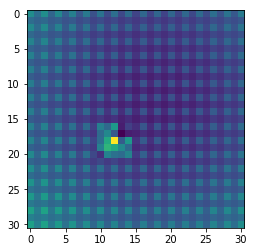

torch.Size([400, 1, 31, 31])


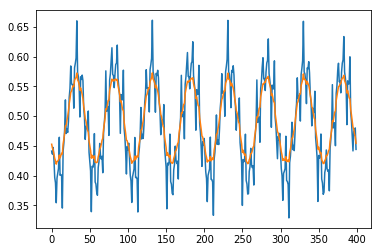

In [122]:
plt.imshow(forward[0,0].cpu().detach().numpy())
plt.show()

plt.plot(forward[:,0,17,10].cpu().detach().numpy())
print(train_data_this.shape)
plt.plot(train_data_this[:,0,17,10].cpu().detach().numpy())

# plt.plot(forward[:,0,17,9].cpu().detach().numpy())

In [86]:
#print indexes where not resolved

resolved_map = model.resolved_maps['0']['0'].cpu().detach().numpy()
for i in range(len(resolved_map)):
    for j in range(len(resolved_map)):
        if resolved_map[i,j] == 0:
            print("(", i , ", ", j, ")")

( 7 ,  5 )
( 7 ,  6 )
( 8 ,  4 )
( 8 ,  5 )
( 8 ,  6 )
( 8 ,  7 )
( 9 ,  4 )
( 9 ,  5 )
( 9 ,  6 )
( 9 ,  7 )
( 10 ,  4 )
( 10 ,  5 )
( 10 ,  6 )
( 10 ,  7 )


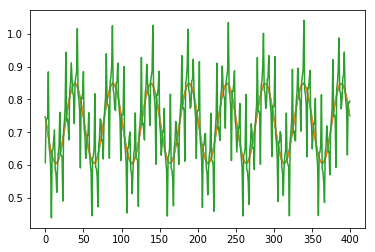

In [87]:
plt.plot(encoded[:,0,7,4].cpu().detach().numpy())
plt.plot(encoded[:,0,7,5].cpu().detach().numpy())
plt.plot(encoded[:,0,8,5].cpu().detach().numpy())


In [24]:
model = models_space['model_L0_0']
resolve_map = model.resolved_maps['0']['0'].cpu().detach().numpy()
print(resolve_map)
nonzeros_idx = np.where(resolve_map.flatten() == 0)[0]
print(nonzeros_idx)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[110 111 124 125 126 127 139 140 141 142 154 155 156 157]


torch.Size([500, 1, 31, 31])


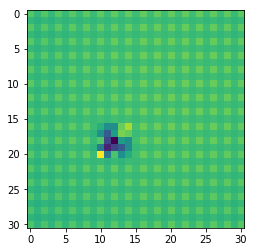

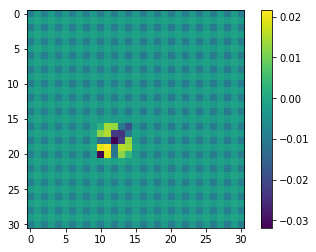

In [30]:
print(forward.shape)
plt.imshow(forward[0,0].cpu().detach().numpy())
plt.show()

plt.imshow((train_data_this[0,0] - forward[0,0]).cpu().detach().numpy())
plt.colorbar()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

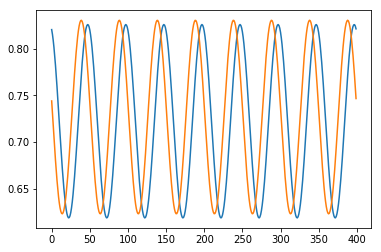

In [7]:
# #encode the data 
model = models_space['model_L0_0']
n_train, n_timesteps, _,_ = train_data.shape
train_encoded = torch.zeros((n_train, n_timesteps, 15,15))
val_encoded = torch.zeros((len(val_data), n_timesteps, 15,15))
data = torch.tensor(train_data).unsqueeze(2).float()

val_data_layer0 = torch.zeros((len(val_data), n_timesteps, 31,31))
train_data_layer0 = torch.zeros((len(train_data), n_timesteps, 31,31))
for i in tqdm(range(len(train_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
    train_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    train_encoded[i] = encoded[:,0]

data = torch.tensor(val_data).unsqueeze(2).float()
for i in tqdm(range(len(val_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
#     print(data_this.shape)
    val_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    val_encoded[i] = encoded[:,0]
    
#plot to make sure they are relatively the same 
plt.plot(val_encoded[1,:,0,0].cpu().detach().numpy())

plt.plot(train_encoded[0,:,0,0].cpu().detach().numpy())

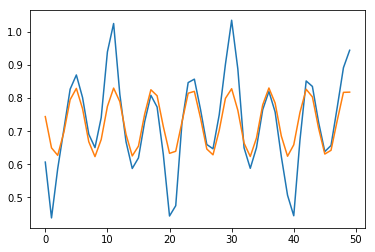

In [8]:
plt.plot(train_encoded[0,::8,8,5].cpu().detach().numpy())
plt.plot(train_encoded[0,::8,0,0].cpu().detach().numpy())

In [ ]:
plt.plot(train_encoded[0,:,7,5].cpu().detach().numpy())

In [12]:
#doing the time training
print("inside train_one_timestep")
i=None
j=None
step_size = 4
dt=1
n_forward = 5
arch = [225, 225*2, 225*2, 225*2, 225]
batch_size = 500
lr = 0.001
# if (i is not None) and (j is not None):
#     model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size, step_size, noise, i, j)
# else:
model_name = 'model_L0_0_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)

dataset = utils.DataSet(train_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), dt, step_size, n_forward)
print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# # training
model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
            model_path=os.path.join(model_path, model_name))

# # try: #if we already have a model saved
# #     if make_new:
# #         print("Making a new model. Old one deleted. model {}".format(model_name))
# #         assert False
# #     model_time = torch.load(model_path_this)
# #     print("model loaded: ", model_name)
# #     if dont_train: #just load model, no training
# #         print("Model not trained more")
# # #         return model_time
# # except:
# print('create model {} ...'.format(model_path_this))
# model_time = tnet.ResNet(train_data, val_data, step_size,
#                          model_name=model_name, model_dir=model_path, n_inputs=n_inputs,
#                          n_hidden_nodes=20, n_hidden_layers=5, out_dim=15*15,
#                          activation=nn.ReLU(), n_epochs=max_epochs,
#                          threshold=threshold, print_every=print_every,
#                          save_every=save_every)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device = ", device)
# model_time.to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model_time.parameters())

# model_time.train_model(optimizer, criterion)

inside train_one_timestep
create model model_L0_0_4.pt ...


/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:step_size, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_x = torch.tensor(val_data[:, x_idx, :]).float().to(self.device)
/home/kjohn

epoch 1000, training loss 0.0009843476582318544, validation loss 0.4400671124458313
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.00041574769420549273, validation loss 0.4691523313522339
epoch 3000, training loss 0.00045283939107321203, validation loss 0.22810733318328857
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.001358128385618329, validation loss 0.13642925024032593
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.0003501015016809106, validation loss 0.09184302389621735
(--> new model saved @ epoch 5000)
epoch 6000, training loss 0.00040012001409195364, validation loss 0.09608995914459229
epoch 7000, training loss 0.0005496982485055923, validation loss 0.02991243451833725
(--> new model saved @ epoch 7000)
epoch 8000, training loss 0.0006724615814164281, validation loss 0.024040548130869865
(--> new model saved @ epoch 8000)
epoch 9000, training loss 0.00032496880157850683, validation loss 0.0206789318472147
(--> new model saved @ e

In [8]:
# model_time = torch.load(model_path_this)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_time.to(device)
# model_time.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
#             model_path=os.path.join(model_path, model_name))

NameError: name 'model_path_this' is not defined

In [13]:
# load models
step_sizes = [4, 8,16]
models_time = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

model_L0_0_4.pt
model_L0_0_8.pt
model_L0_0_16.pt


In [14]:
# model, y_preds = uni_scale_forecast(model, torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
print(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float().shape)


torch.Size([500, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([500, 400, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([500, 400, 15, 15])
torch.Size([500, 225])
False


/home/kjohnst/multiscale_HiTS/src/ResNet.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


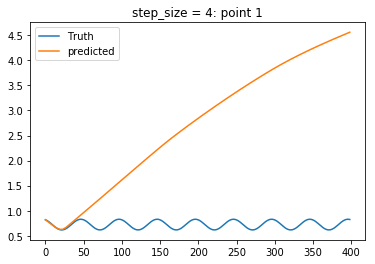

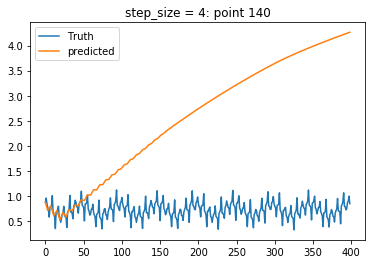

No handles with labels found to put in legend.


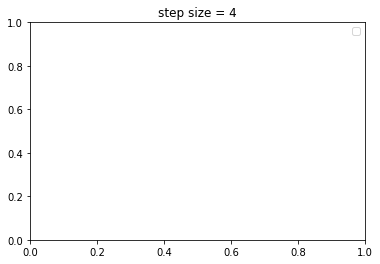

torch.Size([500, 400, 15, 15])
torch.Size([500, 225])
False


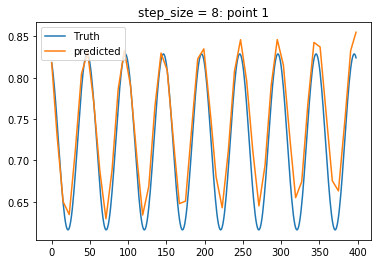

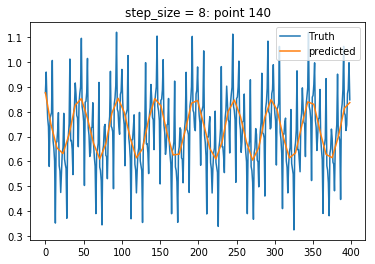

No handles with labels found to put in legend.


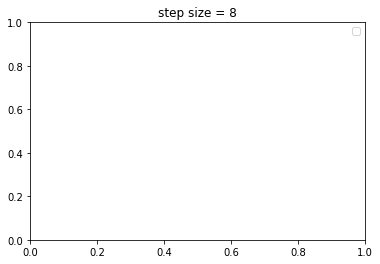

torch.Size([500, 400, 15, 15])
torch.Size([500, 225])
False


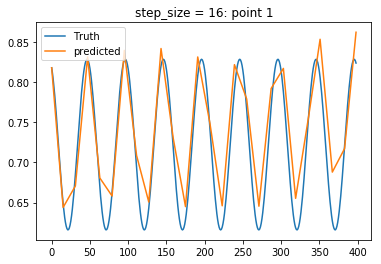

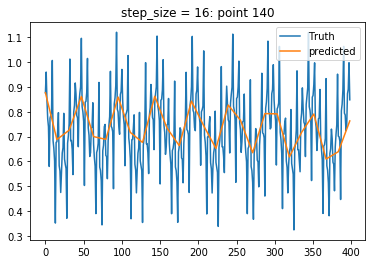

No handles with labels found to put in legend.


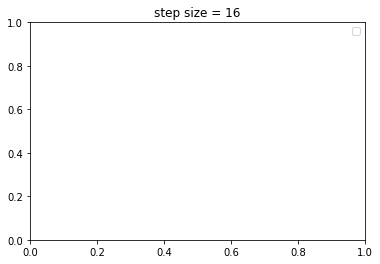

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


(array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ]),
 <a list of 10 Text yticklabel objects>)

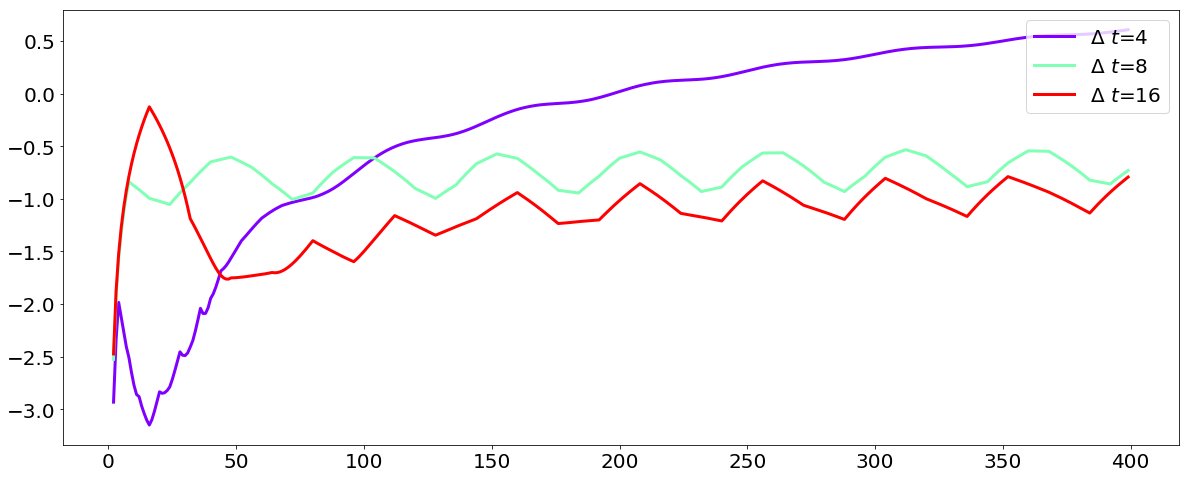

In [15]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
print(test_data.shape)

n_steps = n_timesteps-1
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded.shape)
    print(val_encoded[:, 0, :].flatten(start_dim=1).float().shape)
    print(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float().is_cuda)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 1, :]).flatten(start_dim=1).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float(), y_preds).mean(-1))
    for i in [1,140]:#range(1):
        
        plt.plot(test_data[1, 1:, i].detach().numpy(), label="Truth")
        plt.plot(y_preds[1,:,i], label="predicted")
        x = y_preds[1,::model.step_size,i]
        plt.legend()
        plt.title("step_size = " + str(model.step_size) + ": point " + str(i))
        plt.show()
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
    plt.legend()
    plt.title("step size = "+ str(model.step_size))
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [16]:
import torch
import numpy as np
import scipy.interpolate
from utils import DataSet

def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)

    # vectorized simulation
    indices.append(0)
    preds[:, 0, :] = x_init
    total_step_sizes = n_steps
    for model in models:
        n_forward = int(total_step_sizes/model.step_size)
        y_prev = preds[:, indices, :].reshape(-1, n_dim)
        indices_lists = [indices]
        for t in range(n_forward):
            y_next = model(y_prev)
            shifted_indices = [x + (t + 1) * model.step_size for x in indices]
            indices_lists.append(shifted_indices)
            preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
            y_prev = y_next
        indices = [val for tup in zip(*indices_lists) for val in tup]
        total_step_sizes = model.step_size - 1

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


torch.Size([500, 400, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


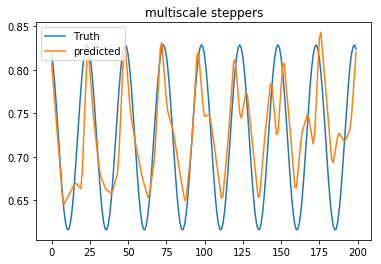

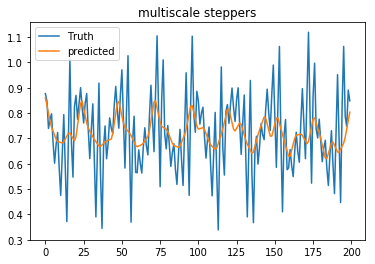

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


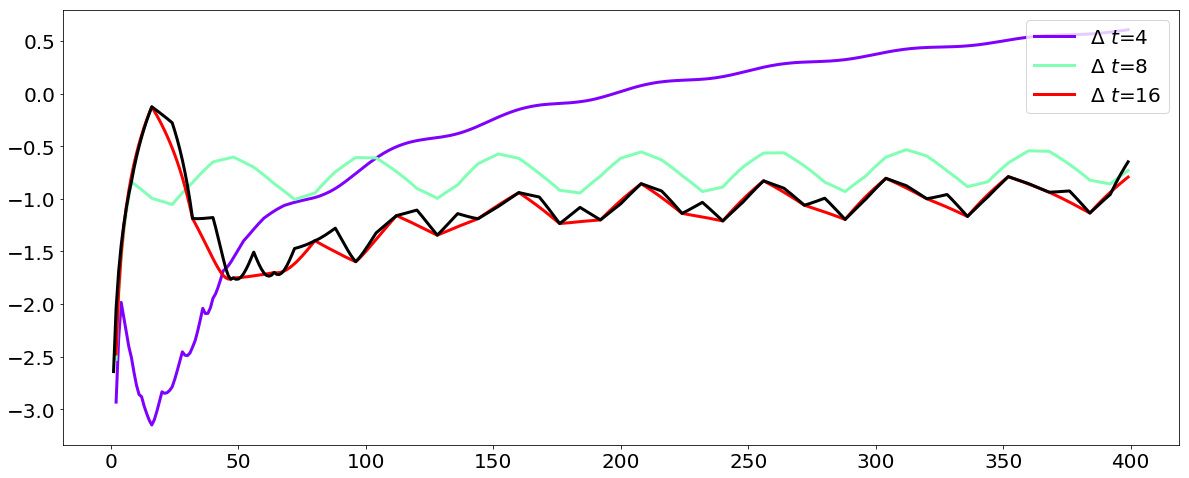

In [19]:
# uniscale time-stepping with NN
# preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
print(test_data.shape)

n_steps = n_timesteps-1
y_preds = vectorized_multi_scale_forecast(torch.tensor(val_encoded[:, 1, :]).flatten(start_dim=1).float().to('cpu'), 
                                          n_steps=n_steps, models=models_time[1:])

preds_mse_this = criterion(torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float(), y_preds).mean(-1)
for i in [1,140]:#range(1):

    plt.plot(test_data[1, 1::2, i].detach().numpy(),label="Truth")
    plt.plot(y_preds[1,::2,i], label="predicted")
    plt.title("multiscale steppers")
    plt.legend()
    plt.show()
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
#     plt.legend()
#     plt.title("step size = "+ str(model.step_size))
#     plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

mean = preds_mse_this.mean(0).detach().numpy()
# rgb = next(colors)
plt.plot(t, np.log10(mean), 'k', linestyle='-', linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))

model_L0_0_8.pt
torch.Size([500, 400, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([500, 400, 15, 15])
torch.Size([500, 225])
False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kjohnst/multiscale_HiTS/src/ResNet.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

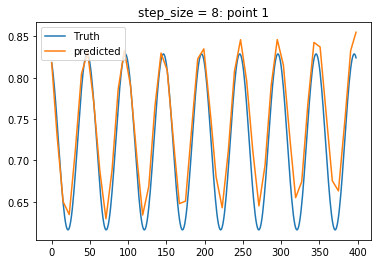

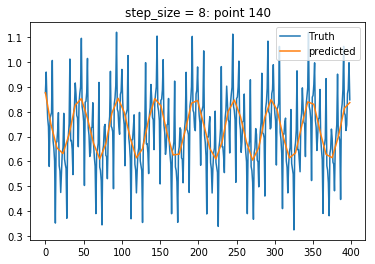

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


(array([-2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
        -0.5 , -0.25]), <a list of 11 Text yticklabel objects>)

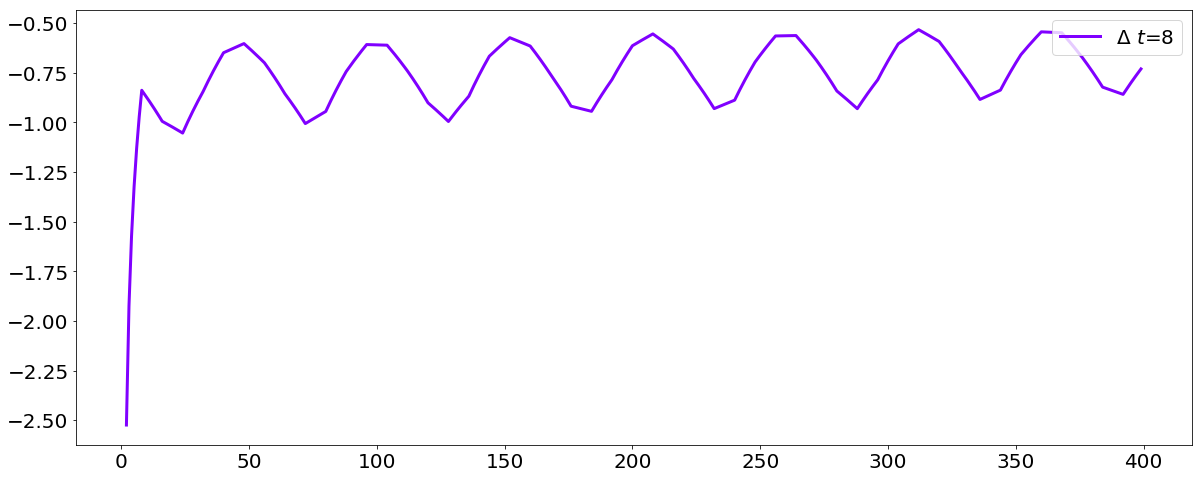

In [88]:
# load models
step_sizes = [8]
models_time = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
    
    
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
print(test_data.shape)

n_steps = n_timesteps-1
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded.shape)
    print(val_encoded[:, 0, :].flatten(start_dim=1).float().shape)
    print(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float().is_cuda)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 1, :]).flatten(start_dim=1).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float(), y_preds).mean(-1))
    for i in [1,140]:#range(1):
        
        plt.plot(test_data[1, 1:, i].detach().numpy(), label="Truth")
        plt.plot(y_preds[1,:,i], label="predicted")
        x = y_preds[1,::model.step_size,i]
        plt.legend()
        plt.title("step_size = " + str(model.step_size) + ": point " + str(i))
        plt.show()

    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [90]:
#fit the difference with smaller timescale

#the data will be the difference 

n_steps = 400-1
for model in tqdm(models_time):
    y_preds_val = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
    y_preds_train = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)

step_size = 4
        
print(torch.tensor(train_encoded).flatten(start_dim=2).float()[:, 1:, nonzeros_idx].shape)
train_data_this = (torch.tensor(train_encoded[:, 1:, :]).flatten(start_dim=2).float() - y_preds_train)[:,:,nonzeros_idx]
val_data_this = (torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float() - y_preds_val)[:,:,nonzeros_idx]

#normalize
max_val = torch.max(train_data_this)
min_val = torch.min(train_data_this)

train_data_this = (train_data_this - min_val) / (max_val - min_val)
val_data_this = (val_data_this - min_val) / (max_val - min_val)

test_data = val_data_this

points_keep = 30
train_data_this = torch.cat((train_data_this[:,:points_keep] , train_data_this[:,points_keep:2*points_keep]))
val_data_this = torch.cat((val_data_this[:,:points_keep] , val_data_this[:,points_keep:2*points_keep]))
dataset = utils.DataSet(train_data_this, val_data_this, val_data_this, dt, step_size, n_forward)

# print(dataset.train_x.shape[1])


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/kjohnst/multiscale_HiTS/src/ResNet.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([500, 399, 14])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [28]:
train_data_this.shape

torch.Size([500, 399, 225])

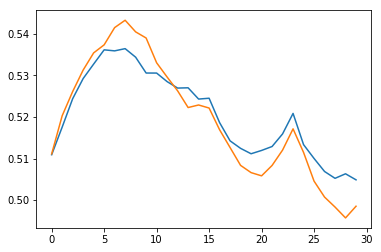

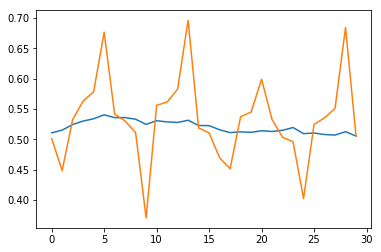

In [91]:
plt.plot(val_data_this[0,:,0])
plt.plot(val_data_this[0,:,1])
# plt.xlim([0,50])
plt.show()
plt.plot(val_data_this[0,:,2])
plt.plot(val_data_this[0,:,3])

In [74]:
step_size

1

In [92]:
#doing the time training
print("inside train_one_timestep")
i=None
j=None
# step_size = 2
dt=1
n_forward = 5
arch = [dataset.n_dim, 128,128,128, dataset.n_dim]
batch_size = 500
lr = 0.001
# if (i is not None) and (j is not None):
#     model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size, step_size, noise, i, j)
# else:
model_name = 'model_L0_1_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)

# model  = torch.load(model_path_this)
# print("model loaded ", model_name)

print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# # training
model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
            model_path=os.path.join(model_path, model_name))

# # try: #if we already have a model saved
# #     if make_new:
# #         print("Making a new model. Old one deleted. model {}".format(model_name))
# #         assert False
# #     model_time = torch.load(model_path_this)
# #     print("model loaded: ", model_name)
# #     if dont_train: #just load model, no training
# #         print("Model not trained more")
# # #         return model_time
# # except:
# print('create model {} ...'.format(model_path_this))
# model_time = tnet.ResNet(train_data, val_data, step_size,
#                          model_name=model_name, model_dir=model_path, n_inputs=n_inputs,
#                          n_hidden_nodes=20, n_hidden_layers=5, out_dim=15*15,
#                          activation=nn.ReLU(), n_epochs=max_epochs,
#                          threshold=threshold, print_every=print_every,
#                          save_every=save_every)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device = ", device)
# model_time.to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model_time.parameters())

# model_time.train_model(optimizer, criterion)

inside train_one_timestep
create model model_L0_1_4.pt ...
epoch 1000, training loss 0.0009603113285265863, validation loss 0.07949935644865036
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.0008618635474704206, validation loss 0.08032319694757462
epoch 3000, training loss 0.0008504018187522888, validation loss 0.08205190300941467
epoch 4000, training loss 0.0008052945486269891, validation loss 0.09055300056934357


KeyboardInterrupt: 

In [85]:
# load models
step_sizes = [step_size]
models_time = list()
for step_size in step_sizes:
    print('model_L0_1_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_1_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

model_L0_1_2.pt


  0%|          | 0/1 [00:00<?, ?it/s]

/home/kjohnst/multiscale_HiTS/src/ResNet.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


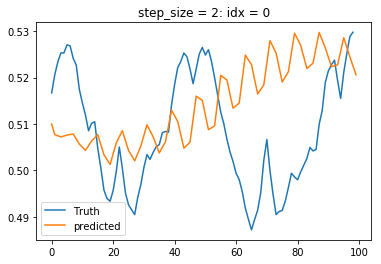

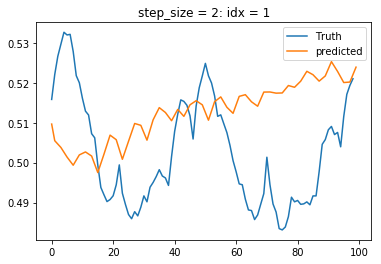

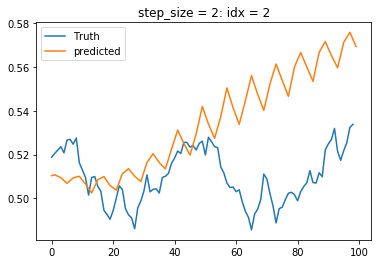

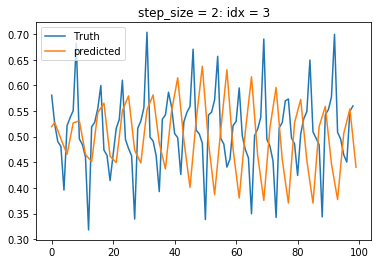

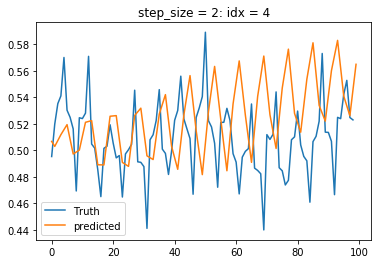

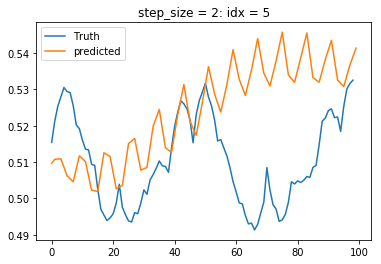

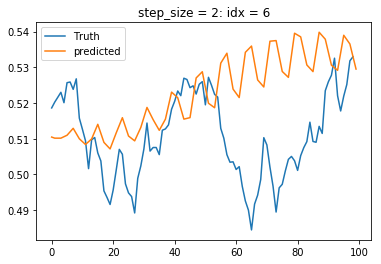

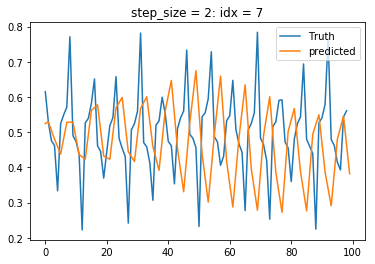

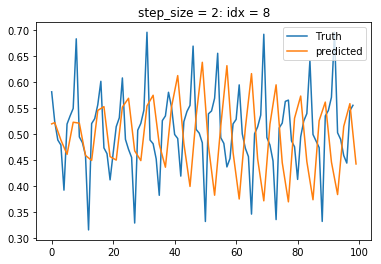

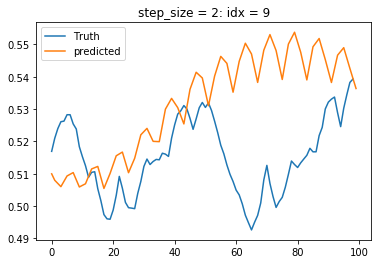

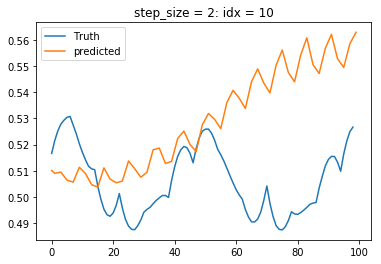

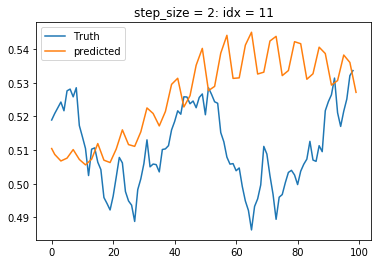

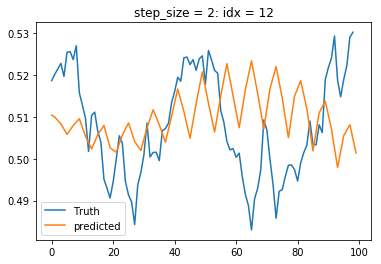

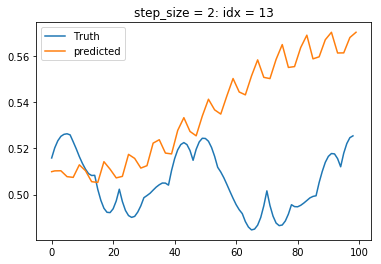

(array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 <a list of 8 Text yticklabel objects>)

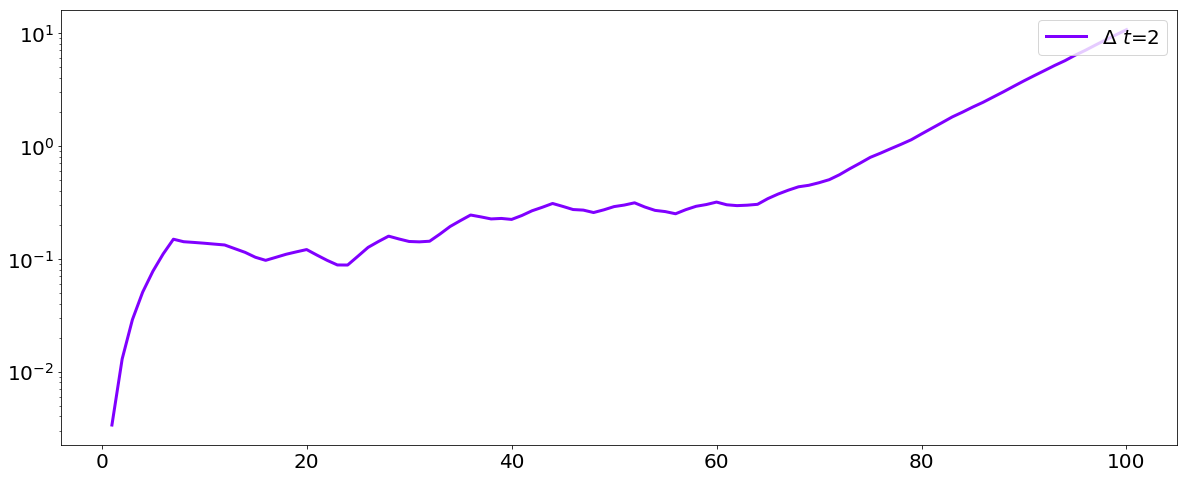

In [86]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

# test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
# print(test_data.shape)

# val_data_smaller = val_data_this#[:,:,nonzeros_idx]
n_steps = 100
for model in tqdm(models_time):
    y_preds = model.uni_scale_forecast(test_data[:,0], n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)

    preds_mse.append(criterion(torch.tensor(test_data[:,1:n_steps+1]), y_preds).mean(-1))
    for i in range(val_data_smaller.shape[-1]):#range(1):
        
        plt.plot(test_data[1, 1:n_steps, i].detach().numpy(),label="Truth")
        plt.plot(y_preds[1,:n_steps,i], label="predicted")
        plt.legend()
        plt.title("step_size = " + str(model.step_size) + ": idx = " + str(i))
#         plt.ylim([torch.min(val_data_this), torch.max(val_data_this)])
#         plt.xlim([0,100])
#         plt.ylim([-1,2])
        plt.show()

    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t[:n_steps], mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [142]:
print(val_data_smaller.shape)

torch.Size([1000, 20, 14])


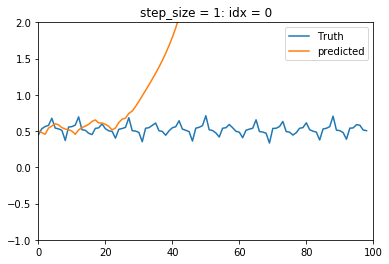

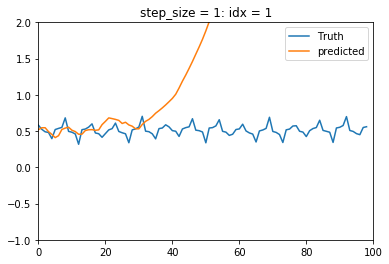

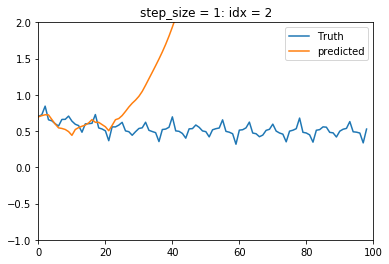

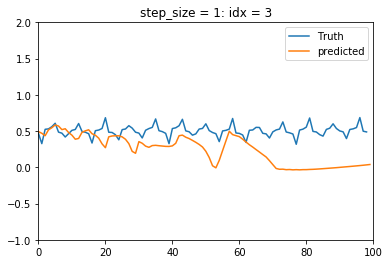

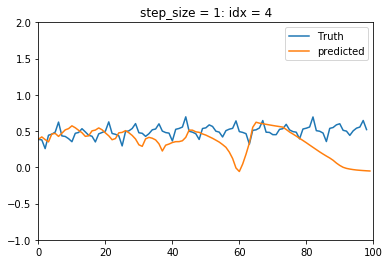

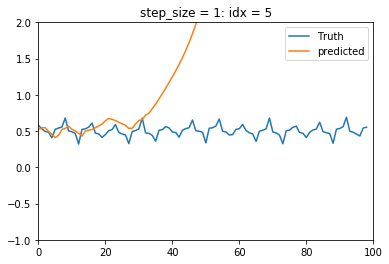

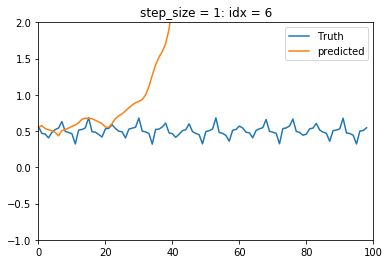

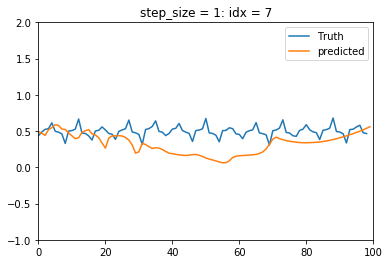

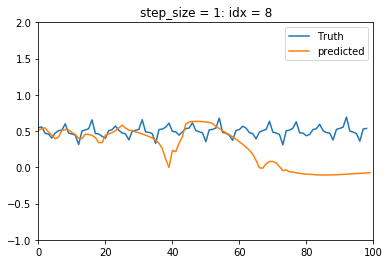

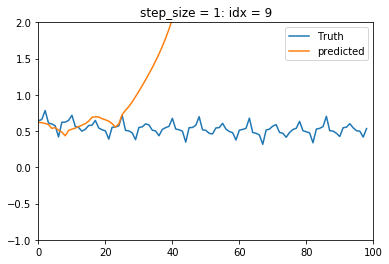

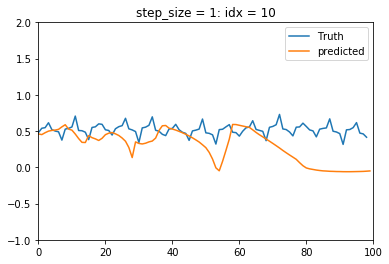

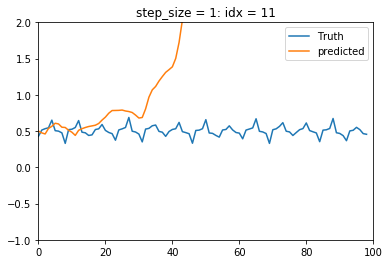

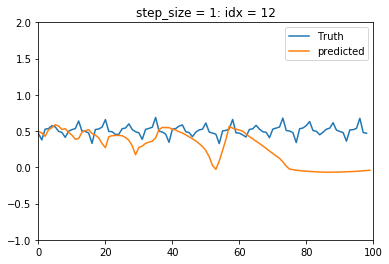

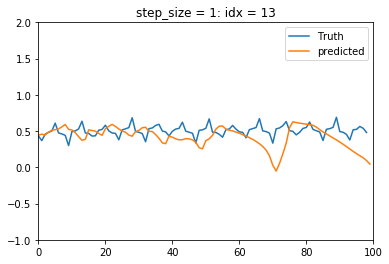

In [65]:
for i in range(val_data_smaller.shape[-1]):#range(1):
        
        plt.plot(val_data_smaller[i, 1:n_steps, 3].detach().numpy(),label="Truth")
        plt.plot(y_preds[i,:n_steps,3], label="predicted")
        plt.legend()
        plt.title("step_size = " + str(model.step_size) + ": idx = " + str(i))
#         plt.ylim([torch.min(val_data_this), torch.max(val_data_this)])
        plt.xlim([0,100])
        plt.ylim([-1,2])
        plt.show()

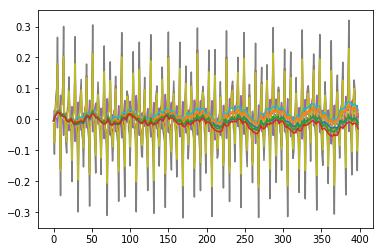

In [47]:
plt.plot(val_data_smaller[0])

model_L0_0_8.pt


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([100, 500, 15, 15])
torch.Size([100, 225])
False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


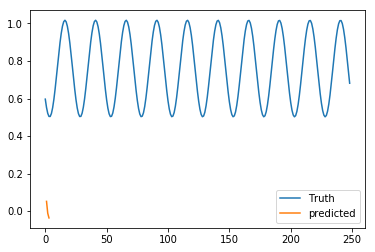

IndexError: index 140 is out of bounds for dimension 2 with size 4

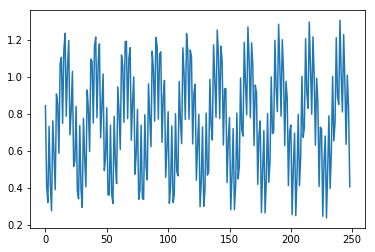

In [318]:
#putting it altogether

# load models
step_sizes = [8]
models_time = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
    
#fit first step 

n_steps = 498
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded.shape)
    print(val_encoded[:, 0, :].flatten(start_dim=1).float().shape)
    print(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float().is_cuda)
    y_preds_large = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
#     preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:n_steps+1, :]).flatten(start_dim=2).float(), y_preds_large).mean(-1))
    for i in [1,140]:#range(1):
        
        plt.plot(test_data[1, 1:n_steps:2, i].detach().numpy(),label="Truth")
        plt.plot(y_preds[1,::2,i], label="predicted")
        x = y_preds[1,::model.step_size,i]
        plt.legend()
        plt.show()
        
        
preds_mse_large = criterion(torch.tensor(val_encoded[:, 1:n_steps+1, :]).flatten(start_dim=2).float(), y_preds_large).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))

err = preds_mse
mean = err.mean(0).detach().numpy()
rgb = next(colors)
plt.semilogy(t[:n_steps], mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([2e-4,1e-2])

In [325]:
model = models_time[0]
y_preds = uni_scale_forecast(model, torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=8)
print(y_preds[:,0,0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


3
[0, 7, 15]
(100, 225, 3)
torch.Size([100, 8, 225])
tensor([0.5251, 0.6268, 0.9422, 0.6134, 0.5590, 0.5492, 0.7318, 0.5101, 0.8009,
        0.6221, 0.6882, 0.8502, 0.5484, 0.5104, 0.9533, 0.8345, 0.5160, 0.5388,
        0.6844, 0.9270, 1.0008, 0.5338, 0.5558, 0.8229, 0.8287, 0.8518, 0.7889,
        0.5178, 0.8246, 0.5106, 0.6898, 0.9551, 0.9838, 0.8617, 0.8362, 0.7952,
        0.5112, 0.5420, 0.7522, 0.6532, 0.5100, 0.6059, 0.5151, 0.7955, 0.6187,
        0.8621, 0.8609, 0.8422, 0.7162, 0.9535, 0.5427, 0.6774, 1.0096, 0.7302,
        0.6034, 1.0081, 1.0098, 1.0094, 0.5139, 0.9155, 0.9973, 0.5186, 0.5688,
        0.5207, 0.7405, 1.0061, 0.8043, 0.5525, 0.8945, 1.0011, 0.5937, 0.8230,
        0.6280, 1.0016, 0.7147, 0.6055, 0.6800, 0.9824, 0.9904, 0.5171, 0.8365,
        0.5337, 0.5179, 0.5393, 0.6138, 0.8222, 0.6749, 0.6992, 0.7519, 0.5817,
        0.6979, 0.5276, 0.5172, 0.6562, 0.7847, 0.6170, 0.5102, 0.9497, 0.8760,
        0.6913])


model_L0_1_1.pt


  0%|          | 0/1 [00:00<?, ?it/s]

n_steps =  498
val_data_this shape = torch.Size([100, 499, 225])


/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


y_preds shape= torch.Size([100, 498, 4])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


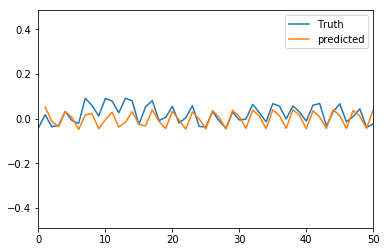

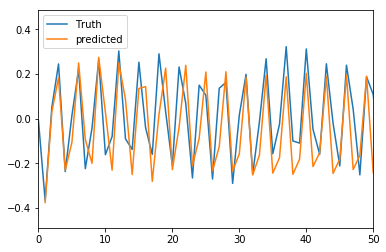

In [326]:
# load models
step_sizes = [1]
models_time = list()
for step_size in step_sizes:
    print('model_L0_1_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_1_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

# test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
# print(test_data.shape)

val_data_smaller = val_data_this[:,:,nonzeros_idx]
# n_steps = 100
for model in tqdm(models_time):
    print("n_steps = ", n_steps)
    print("val_data_this shape =", val_data_this.shape)
    y_preds_small = model.uni_scale_forecast(val_data_smaller[:,0], n_steps=n_steps)
    print("y_preds shape=", y_preds_small.shape)
#     end = time.time()
#     times.append(end - start)

    preds_mse.append(criterion(torch.tensor(val_data_smaller[:,1:n_steps+1]), y_preds_small).mean(-1))
    for i in [1,2]:#range(1):
        
        plt.plot(val_data_smaller[1, 1::2, i].detach().numpy(),label="Truth")
        plt.plot(y_preds_small[1,::2,i], label="predicted")
        x = y_preds[1,::model.step_size,i]
        plt.legend()
        plt.ylim([torch.min(val_data_this), torch.max(val_data_this)])
        plt.xlim([0,50])
        plt.show()

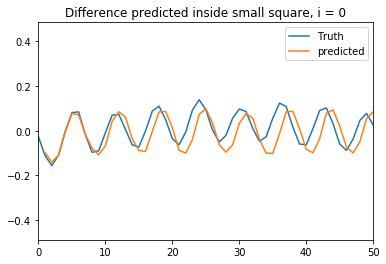

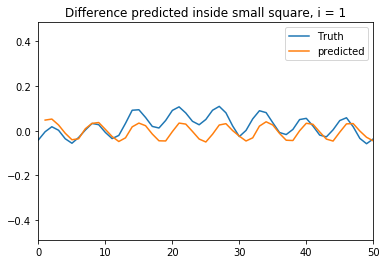

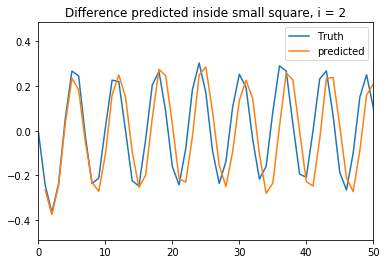

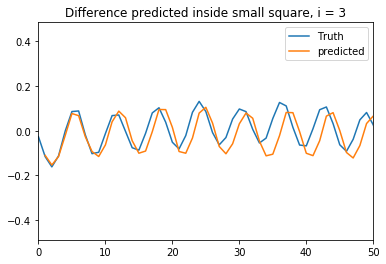

In [377]:
for i in [0,1,2,3]:#range(1):
        
        plt.plot(val_data_smaller[1, 1:, i].detach().numpy(),label="Truth")
        plt.plot(y_preds_small[1,:,i], label="predicted")
        plt.legend()
        plt.ylim([torch.min(val_data_this), torch.max(val_data_this)])
        plt.title("Difference predicted inside small square, i = "+ str(i))
        plt.xlim([0,50])
        plt.show()

In [344]:
    def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        if self.step_size>1:
            cur_step = self.step_size - 1
        else:
            cur_step = self.step_size
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next
            
        print(steps)

        # include the initial frame
        steps.insert(0, 0)
        preds.insert(0, torch.tensor(x_init).float().to(self.device))

#         print(preds[0])
#         print(preds[1])
        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        print(len(steps))
        print(preds.shape)
        print(steps)
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()
        
        print(y_preds.shape)
        
        plt.plot(steps, preds[0,0], '.')
        plt.plot(y_preds[0,:,0])
        plt.show()

        return y_preds

[1, 2, 3, 4, 5, 6, 7, 8]
9
(100, 4, 9)
[0, 1, 2, 3, 4, 5, 6, 7, 8]
torch.Size([100, 8, 4])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


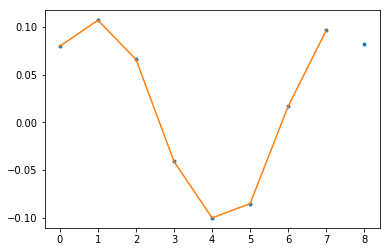

tensor([ 0.0800,  0.0139, -0.1052, -0.0303, -0.0759, -0.0286, -0.1099, -0.0678,
        -0.0351, -0.0004,  0.0071,  0.0549, -0.0232, -0.0669, -0.0679,  0.0459,
         0.0357,  0.0323,  0.0164, -0.1187,  0.0174,  0.0593, -0.0612,  0.0253,
         0.0368,  0.0544, -0.0688,  0.0549,  0.0290, -0.0646,  0.0016, -0.0615,
         0.0690,  0.0447,  0.0485, -0.0509, -0.0420,  0.0142, -0.1275,  0.0576,
        -0.0846, -0.0558,  0.0268, -0.0499, -0.0121,  0.0440,  0.0465,  0.0536,
        -0.0745, -0.0667,  0.0077,  0.0332, -0.0926, -0.1079, -0.0643, -0.0798,
        -0.0919, -0.0944,  0.0071, -0.1042,  0.0428,  0.0573, -0.1054,  0.0711,
        -0.1222, -0.0538, -0.0245, -0.0450, -0.0429,  0.0115, -0.0930,  0.0256,
         0.0167,  0.0083, -0.0717, -0.0583,  0.0280,  0.0653,  0.0716,  0.0444,
         0.0487,  0.0595,  0.0543,  0.0308, -0.0278,  0.0233,  0.0379, -0.0261,
        -0.1275, -0.1130, -0.0206,  0.0783,  0.0457,  0.0580, -0.0803, -0.0173,
        -0.0792, -0.0815,  0.0142, -0.00

In [345]:
y_preds = uni_scale_forecast(model, val_data_smaller[:,0], n_steps=8)
print(y_preds[:,0,0])

In [220]:
val_data_smaller.shape

torch.Size([100, 499, 4])

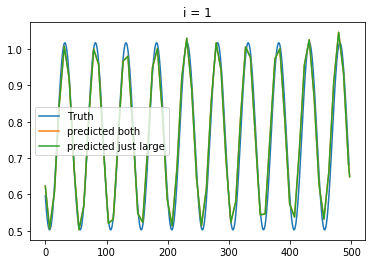

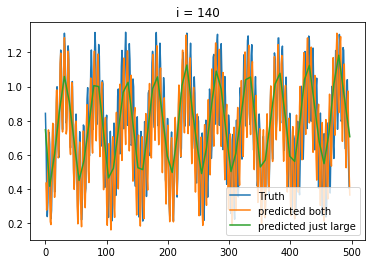

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(0, 100)

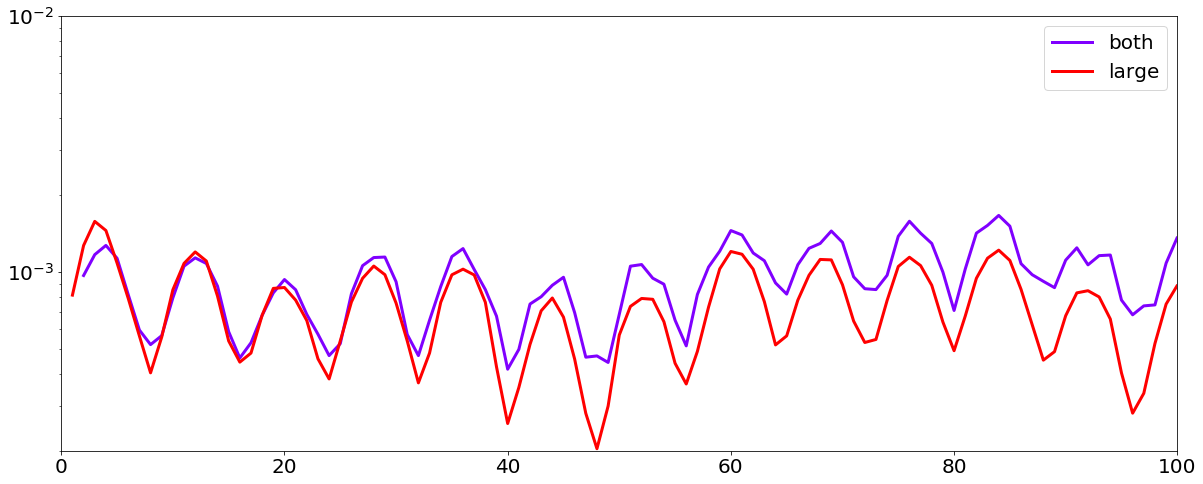

In [381]:
#add the two together

y_preds_together = y_preds_large.clone()
for idx_small, idx_large in enumerate(nonzeros_idx):
    y_preds_together[:,:,idx_large] += y_preds_small[:,:,idx_small]

for i in [1,140]:#range(1):
        
        plt.plot(test_data[1, 1:n_steps, i].detach().numpy(),label="Truth")
        plt.plot(y_preds_together[1,:,i], label="predicted both")
        plt.plot(y_preds_large[1,:,i], label="predicted just large")
#         x = y_preds[1,::model.step_size,i]
        plt.legend()
        plt.title("i = " + str(i))
#         plt.xlim([0,100])
        plt.show()
        
#finding and plotting mse

preds_mse = criterion(torch.tensor(val_encoded[:, 1:n_steps+1, :]).flatten(start_dim=2).float(), y_preds_together).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, 2)))

err = preds_mse
mean = err.mean(0).detach().numpy()
rgb = next(colors)
plt.semilogy(t[:n_steps], mean, linestyle='-', color=rgb, linewidth=3.0, label = "both")#label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([2e-4,1e-2])

err = preds_mse_large
mean = err.mean(0).detach().numpy()
rgb = next(colors)
plt.semilogy(t[:n_steps], mean, linestyle='-', color=rgb, linewidth=3.0, label = "large")#label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([2e-4,1e-2])

plt.xlim([0,100])

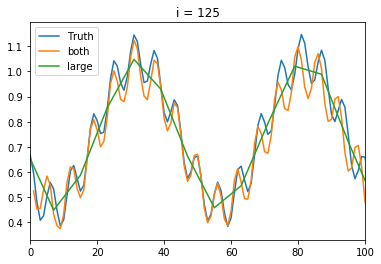

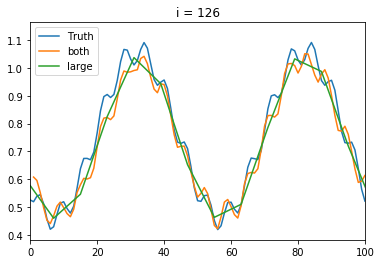

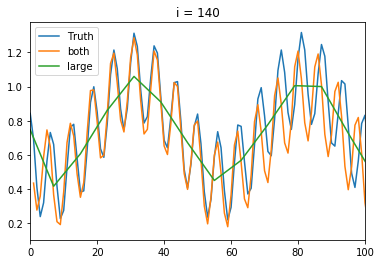

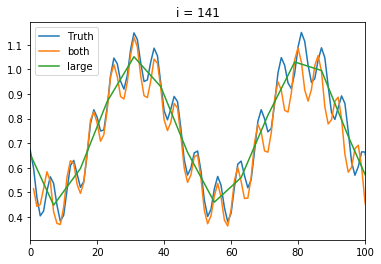

In [380]:
for i in nonzeros_idx:#range(1):
        
        plt.plot(test_data[1, 1:n_steps, i].detach().numpy(),label="Truth")
        plt.plot(y_preds_together[1,:,i], label="both")
        plt.plot(y_preds_large[1,:,i], label="large")
        plt.title("i = "+str(i))
        plt.legend()
        plt.xlim([0,100])
        plt.show()

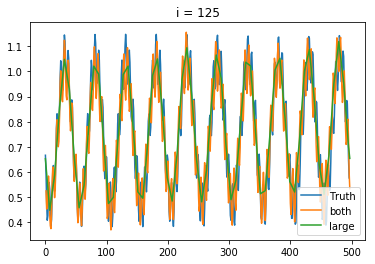

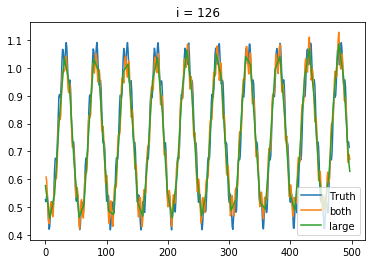

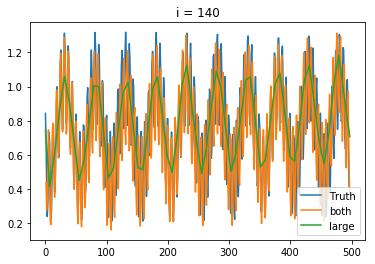

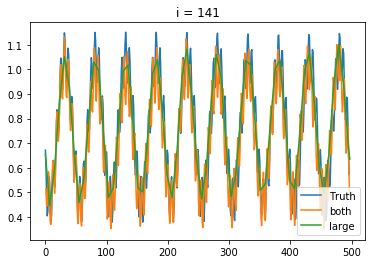

In [382]:
for i in nonzeros_idx:#range(1):
        
        plt.plot(test_data[1, 1:n_steps, i].detach().numpy(),label="Truth")
        plt.plot(y_preds_together[1,:,i], label="both")
        plt.plot(y_preds_large[1,:,i], label="large")
        plt.title("i = "+str(i))
        plt.legend()
#         plt.xlim([0,100])
        plt.show()

In [425]:
#see how the error is after decode

model = models_space['model_L0_0']
val_decoded_large = torch.zeros((len(val_data), 498, 31,31))
data = y_preds_large.reshape((100,498,15,15)).unsqueeze(2).float().to(device)
for i in tqdm(range(len(val_data))):
    decoded = decode(model, data[i], 0)
    val_decoded_large[i] = decoded[:,0]
    
val_decoded_together = torch.zeros((len(val_data), 498, 31,31))
data = y_preds_together.reshape((100,498,15,15)).unsqueeze(2).float().to(device)
for i in tqdm(range(len(val_data))):
    decoded = decode(model, data[i], 0)
    val_decoded_together[i] = decoded[:,0]
    
# print(y_preds_large.shape)
# print(data_this.shape)
# print(val_encoded.shape)
# val_decoded_large = torch.zeros(100,498,31,31)
# # data = torch.tensor(val_data).unsqueeze(2).float()
# for i in tqdm(range(100)):
#     data_this = y_preds_large[0].reshape((n_steps, 1, 15, 15)).to('cuda')
#     decoded = decode(model, data_this, 0)
#     val_decoded_large[i] = decoded[:,0]
    
# val_decoded_together = torch.zeros(100,498,31,31)
# # data = torch.tensor(val_data).unsqueeze(2).float()
# for i in tqdm(range(100)):
#     data_this = y_preds_together[0].reshape((n_steps, 1, 15, 15)).to('cuda')
#     decoded = decode(model, data_this, 0)
#     val_decoded_together[i] = decoded[:,0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

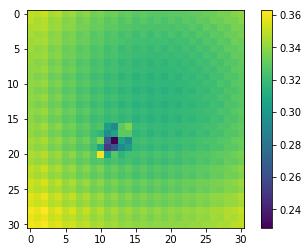

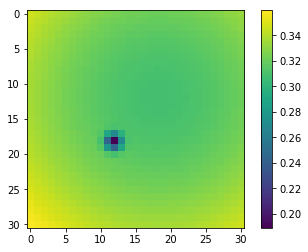

In [423]:
plt.imshow(val_decoded_large[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()


plt.imshow(val_data_layer0[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

Text(0.5,1,'mse of decoded')

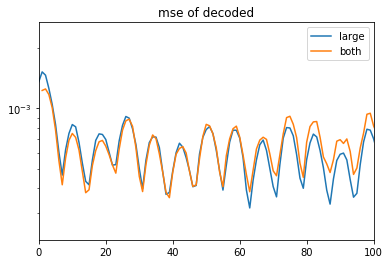

In [433]:
preds_mse_decoded = criterion(val_decoded_large, val_data_layer0[:,2:]).mean(-1).mean(-1)

plt.semilogy(preds_mse_decoded.mean(0).detach().numpy(), label ='large')

preds_mse_decoded = criterion(val_decoded_together, val_data_layer0[:,2:]).mean(-1).mean(-1)

plt.semilogy(preds_mse_decoded.mean(0).detach().numpy(), label='both')
plt.xlim([0,100])
plt.legend()
plt.title("mse of decoded")

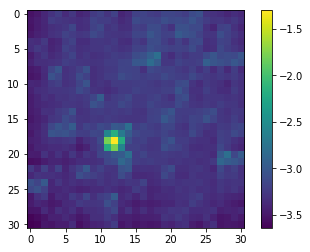

torch.Size([31, 31])


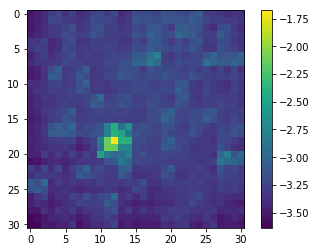

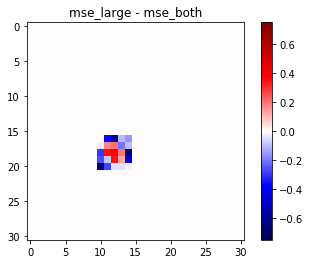

In [466]:
t_max = 50
preds_mse_decoded_large = criterion(val_decoded_large[:,1:t_max+1], val_data_layer0[:,3:t_max+3]).mean(0).mean(0)
plt.imshow(np.log10(preds_mse_decoded_large.detach().numpy()))
plt.colorbar()
plt.show()

preds_mse_decoded_together = criterion(val_decoded_together[:,1:t_max+1], val_data_layer0[:,3:t_max+3]).mean(0).mean(0)
print(preds_mse_decoded.shape)
plt.imshow(np.log10(preds_mse_decoded_together.detach().numpy()))
plt.colorbar()
plt.show()

plt.imshow((np.log10(preds_mse_decoded_large.detach().numpy()) - np.log10(preds_mse_decoded_together.detach().numpy())),cmap=plt.get_cmap('seismic'), vmin=-0.75, vmax=0.75)
plt.title("mse_large - mse_both")
plt.colorbar()
plt.show()

# plt.semilogy(preds_mse_decoded.mean(0).detach().numpy(), label ='large')

# preds_mse_decoded = criterion(val_decoded_together, val_data_layer0[:,2:]).mean(-1).mean(-1)

# plt.semilogy(preds_mse_decoded.mean(0).detach().numpy(), label='both')
# plt.xlim([0,100])
# plt.legend()
# plt.title("mse of decoded")

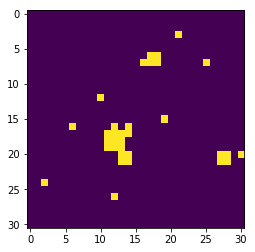

In [468]:
preds_mse_decoded_large_truth = preds_mse_decoded_large>0.001
# print(preds_mse_decoded_together_truth)
plt.imshow(preds_mse_decoded_large_truth)

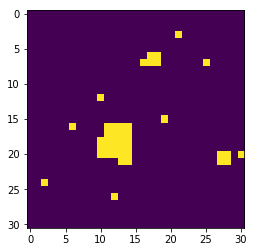

In [467]:
preds_mse_decoded_together_truth = preds_mse_decoded_together>0.001
# print(preds_mse_decoded_together_truth)
plt.imshow(preds_mse_decoded_together_truth)

In [458]:
10**(-3.7)

0.00019952623149688788

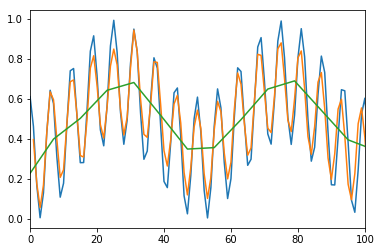

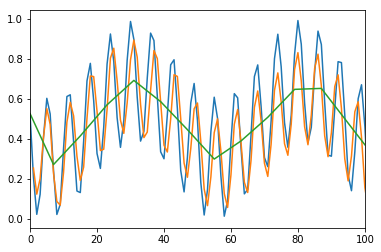

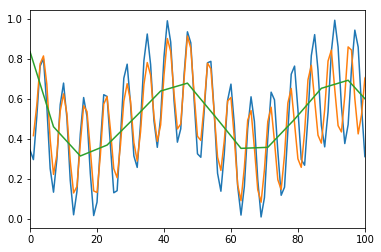

In [432]:
plt.plot(val_data_layer0[0,2:,18,12].detach().numpy())
plt.plot(val_decoded_together[0,:,18,12].detach().numpy())
plt.plot(val_decoded_large[0,:,18,12].detach().numpy())
plt.xlim([0,100])
plt.show()
plt.plot(val_data_layer0[1,2:,18,12].detach().numpy())
plt.plot(val_decoded_together[1,:,18,12].detach().numpy())
plt.plot(val_decoded_large[1,:,18,12].detach().numpy())
plt.xlim([0,100])
plt.show()
plt.plot(val_data_layer0[2,2:,18,12].detach().numpy())
plt.plot(val_decoded_together[2,:,18,12].detach().numpy())
plt.plot(val_decoded_large[2,:,18,12].detach().numpy())
plt.xlim([0,100])
plt.show()

Animating, may take a little while...
..................Done! gif saved to  y_preds_together.gif


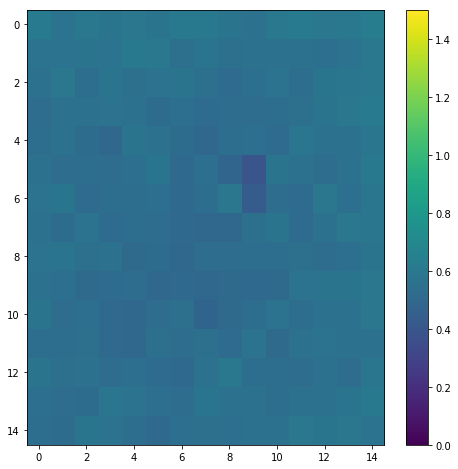

In [372]:
def animate(snapshots, normalize = True, file_name = "animation.gif"):
    """
    Makes an animation of snapshots in time
    
    inputs:
    snapshots: np.array of size (n_time_steps,1, dim, dim)
    normalize = True: whether to fix axis between 0 and 1 or not
    file_name = "animation.gif": file name of where to save gif
    
    outputs:
    no returned output
    gif saved to file_name
    """


    fps = 30
    nSeconds = len(snapshots)/fps
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
#     print(a.shape)
#     print(np.min(snapshots))
#     ghj
    
    
    if normalize:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0.0, vmax=1.0)
    else:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1.5)#vmin=np.min(snapshots), vmax=np.max(snapshots))
    plt.colorbar()

    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig,
                                   animate_func,
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)

    print('Done! gif saved to ', file_name)
    
to_animate = y_preds_together[0].reshape((n_steps, 15,15)).unsqueeze(1).cpu().detach().numpy()
animate(to_animate, False, 'y_preds_together.gif')

In [368]:
print(torch.max(y_preds_together[:,1:]))
print(torch.min(y_preds_together[:,1:]))

tensor(1.5245)
tensor(0.1010)


In [302]:
7+np.arange(len(y_preds_together[1,7::8,0]))*8

array([  7,  15,  23,  31,  39,  47,  55,  63,  71,  79,  87,  95, 103,
       111, 119, 127, 135, 143, 151, 159, 167, 175, 183, 191, 199, 207,
       215, 223, 231, 239, 247, 255, 263, 271, 279, 287, 295, 303, 311,
       319, 327, 335, 343, 351, 359, 367, 375, 383, 391, 399, 407, 415,
       423, 431, 439, 447, 455, 463, 471, 479, 487, 495])

y_preds_small_this shape= torch.Size([100, 8, 4])
tensor([0.0000,    nan, 0.5915, 0.3491, 0.2092, 0.3383, 0.6408, 0.8694])
tensor([0.3753, 0.4038, 0.4322, 0.4606, 0.4890, 0.5174, 0.5458, 0.5742])
tensor([    nan,  0.1594, -0.1115, -0.2798, -0.1791,  0.0950,  0.2952,  0.2204])


/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


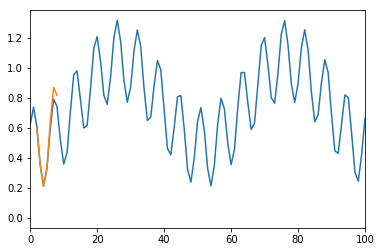

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([100, 225])
torch.Size([100, 225])
y_preds_small_this shape= torch.Size([100, 8, 4])


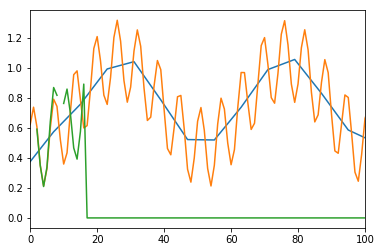

In [295]:
#combine, but reset every 8 steps

# load model
model = torch.load(os.path.join(model_path,'model_L0_1_{}.pt'.format(1)),map_location='cpu')
model.device = 'cpu'
model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    
step_size_large = 8
#copy large one
y_preds_together_2 = torch.zeros(y_preds_large.shape)


# test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
# print(test_data.shape)

val_data_smaller = val_data_this[:,:,nonzeros_idx]
# n_steps_this = # = 100
y_preds_small_this = model.uni_scale_forecast(val_data_smaller[:,0], n_steps=step_size_large)
print("y_preds_small_this shape=", y_preds_small_this.shape)

        
for idx_small, idx_large in enumerate(nonzeros_idx):
    y_preds_together_2[:,1:step_size_large+1,idx_large] = y_preds_large[:,1:step_size_large+1,idx_large] + y_preds_small_this[:,:,idx_small]
    
print(y_preds_together_2[0,:8,140])
print(y_preds_large[0,:8,140])
print(y_preds_small_this[0,:,2])

plt.plot(test_data[0, 1:n_steps, i].detach().numpy(),label="Truth")
plt.plot(y_preds_together_2[0,:9,140])
plt.xlim([0,100])
plt.show()

step_start = 8
step_end = 8 + step_size_large
print(torch.tensor(val_encoded[:, step_start+1, :]).flatten(start_dim=1).float().shape)
print(y_preds_large[:,step_start,:].shape)
val_data_smaller_this = torch.tensor(val_encoded[:, step_start+1, :]).flatten(start_dim=1).float() - y_preds_large[:,step_start,:]
y_preds_small_this = model.uni_scale_forecast(val_data_smaller_this[:,nonzeros_idx], n_steps=step_size_large)
print("y_preds_small_this shape=", y_preds_small_this.shape)

for idx_small, idx_large in enumerate(nonzeros_idx):
        y_preds_together_2[:,step_start+1:step_end+1,idx_large] = y_preds_large[:,step_start+1:step_end+1,idx_large] + y_preds_small_this[:,:,idx_small]

#     y_preds_together_2[:,step_start:step_end,idx_large] += y_preds_small_this[:,:,idx_small]
    
plt.plot(y_preds_large[0,:,i], label="predicted")
plt.plot(test_data[0, 1:, i].detach().numpy(),label="Truth")
plt.plot(y_preds_together_2[0,:,140])

plt.xlim([0,100])
plt.show()

In [35]:
# start = time.time()
# y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
y_preds = tnet.vectorized_multi_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps, models=models_time)
# end = time.time()
# multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(step_sizes)):#len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.semilogy(multiscale_err, linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

# plt.ylim([1e-4, 10])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

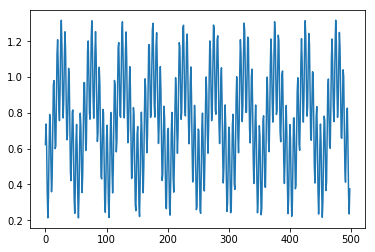

In [36]:
plt.plot(torch.tensor(val_encoded).flatten(start_dim=2)[0,1:,140].cpu().detach().numpy())
for model in tqdm(models_time):
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
    plt.plot(y_preds[0,:,140].cpu().detach().numpy())

y_preds = tnet.vectorized_multi_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps, models=models_time)
    
plt.plot(y_preds[0,:,140].cpu().detach().numpy())
plt.xlim([0,100])

In [ ]:
plt.plot(torch.tensor(val_encoded).flatten(start_dim=2)[0,1:,0].cpu().detach().numpy())
for model in tqdm(models_time):
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
    plt.plot(y_preds[0,:,0].cpu().detach().numpy())

y_preds = tnet.vectorized_multi_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps, models=models_time)
    
plt.plot(y_preds[0,:,0].cpu().detach().numpy())
plt.plot([8,8], [0.5, 0.8], 'k')
plt.xlim([0,100])

In [ ]:
vmin = 0.5
vmax = 0.6
t = 7
plt.imshow(val_encoded[0,t+1].cpu().detach().numpy(),vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()
# plt.plot(torch.tensor(val_encoded).flatten(start_dim=2)[0,1:,0].cpu().detach().numpy())
for model in models_time:
    print(model.step_size)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
    plt.imshow(y_preds[0,t].reshape((15,15)).cpu().detach().numpy(),vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

y_preds = tnet.vectorized_multi_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps, models=models_time)
    
plt.imshow(y_preds[0,t].reshape((15,15)).cpu().detach().numpy(),vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [ ]:
finding_index = torch.zeros((15,15))
finding_index[8,5] = 1
finding_index[9,5] = 1
finding_index[8,6] = 1
finding_index[9,6] = 1
plt.imshow(finding_index.detach().numpy())
finding_index = finding_index.flatten()

print(finding_index.nonzero())

In [ ]:
#making the vectorized just change the 4 squares
import scipy
def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device='cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)

    # vectorized simulation
    indices.append(0)
    preds[:, 0, :] = x_init
    total_step_sizes = n_steps
    
    idx_list = [125, 126,140, 141]
    for model in models:
#         if model.step_size < 8:
#             n_forward = int(total_step_sizes/model.step_size)
#             y_prev = preds[:, indices, :].reshape(-1, n_dim)
#             indices_lists = [indices]
#             for t in range(n_forward):
#                 y_next = model(y_prev.to(device)).to(device)
#     #             print("y_next is cuda = ", y_preds.is_cuda)
#                 shifted_indices = [x + (t + 1) * model.step_size for x in indices]
#                 indices_lists.append(shifted_indices)
#                 for idx in idx_list:
#                      preds[:, shifted_indices, idx] = y_next[:,idx].reshape(n_test, -1)
#                 y_prev = y_next
#             indices = [val for tup in zip(*indices_lists) for val in tup]
#             total_step_sizes = model.step_size - 1
#         else:
            n_forward = int(total_step_sizes/model.step_size)
            y_prev = preds[:, indices, :].reshape(-1, n_dim)
            indices_lists = [indices]
            for t in range(n_forward):

                y_next = model(y_prev.to(device)).to(device)
    #             print("y_next is cuda = ", y_preds.is_cuda)
                shifted_indices = [x + (t + 1) * model.step_size for x in indices]
                indices_lists.append(shifted_indices)
                preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
                y_prev = y_next
            indices = [val for tup in zip(*indices_lists) for val in tup]
            total_step_sizes = model.step_size - 1
            
             # interpolations
            sample_steps = range(1, n_steps+1-8)
            valid_preds = preds[:, indices, :].detach().numpy()
            cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
            y_preds = torch.tensor(cs(sample_steps)).float()

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds



In [ ]:
y_preds = vectorized_multi_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps, models=models_time)


In [ ]:
plt.plot(torch.tensor(val_encoded).flatten(start_dim=2)[0,1:,140].cpu().detach().numpy())
for model in tqdm(models_time):
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[0:1, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
    plt.plot(np.arange(len(y_preds[0,::8,140]))* 8, y_preds[0,::8,140].cpu().detach().numpy(), '.')

y_preds = vectorized_multi_scale_forecast(torch.tensor(val_encoded[0:1, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps, models=models_time)
    
plt.plot(y_preds[0,:,140].cpu().detach().numpy())
plt.plot([8,8], [0.5, 0.8], 'k')
plt.xlim([0,50])

In [ ]:
print(y_preds.shape)
print(np.argmax(y_preds[0,0]))
plt.plot(test_data[0,:,140].cpu().detach().numpy())
plt.plot(y_preds[0,:,140])

In [ ]:
# model = models_time[0]
#get encoded versions of validation adn training
print(torch.tensor(test_data[:, 0, :]).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
print(test_data.shape)
print(y_preds.shape)
encoded_t1_val = torch.reshape(y_preds, (100,499,15,15))
# print(encoded_t1.shape)
print(val_encoded.shape)

print(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=2).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=1).float(), n_steps=n_steps)
print(y_preds.shape)
encoded_t1_train = torch.reshape(y_preds, (len(y_preds),n_steps,15,15))
print(encoded_t1_train.shape)

In [ ]:
plt.imshow(encoded_t1_val[0,96])#, vmin=0.4, vmax=0.6)
plt.colorbar()
plt.title("encoded time t+96 predicted")
plt.show()

print(encoded.shape)
plt.imshow(val_encoded[0,97].cpu().detach().numpy())#, vmin=0.4, vmax=0.6)
plt.title("encoded time t+96 truth")
plt.colorbar()
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15)).shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15))[:,1:].shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,1))
plt.imshow(mse)
plt.colorbar()
plt.show()

In [ ]:
# # trained models at different levels
# models_space = {}
# print('model names: model_L{level}_{index}')
# for file_name in sorted(os.listdir(model_path)):
#     model_name, _ = file_name.split('.')
#     print(model_name)
#     models_space[model_name] = torch.load(os.path.join(model_path, file_name))

In [ ]:
# model = models['model_L0_0']
# print(encoded_t1.shape)
# decoded = decode(model, encoded_t1,0)

# #decode the data 
model = models_space['model_L0_0']
print(encoded_t1_train.shape)
n_train, n_timesteps, _,_ = train_data.shape
train_decoded = torch.zeros((n_train, n_timesteps-1, 31,31))
val_decoded = torch.zeros((len(val_data), n_timesteps-1, 31,31))
data = encoded_t1_train.unsqueeze(2).float().to(device)
for i in tqdm(range(len(train_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    print(decoded.shape)
#     print(train_encoded.shape)
#     print(encoded.shape)
    train_decoded[i] = decoded[:,0]

# data = torch.tensor(val_data).unsqueeze(2).float()
data = encoded_t1_val.unsqueeze(2).float().to(device)
for i in tqdm(range(len(val_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    val_decoded[i] = decoded[:,0]
    

In [ ]:
vmin = 0.35#torch.min(val_decoded[0,0])
vmax = 0.4#torch.max(val_decoded[0,0])

plt.imshow(val_decoded[0,96].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.title("Decoded t+96 predicted")
plt.colorbar()
plt.show()

data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.imshow(val_data_layer0[0,97].cpu().detach().numpy(),vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("t+96 truth")
plt.show()

# print(train_decoded[0].shape)
# print(data_this[1:,0].shape)

print(val_data_layer0.shape)
print(val_decoded.shape)
mse = np.mean(((val_decoded.cpu() - val_data_layer0[:,1:].cpu())**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.title("mse for decoded data")
plt.show()

In [ ]:
plt.plot(val_data_layer0[0,:,18,12])
plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())

In [ ]:
class MultiScaleDynamicsDataSet():
    def __init__(self, train_data, val_data, train_data_output, val_data_output, n_levels, map_path=None, train_ratio=0.7, valid_ratio=0.2):
        # load data
#         data = np.load(data_path)
#         self.data = torch.tensor(data).unsqueeze(1).float()
#         #
#         if map_path is not None:
#             map_data = 1 - np.load(map_path)
#             self.map_data = torch.tensor(map_data).float()
#         else:
        

        self.nt, self.nx, self.ny = train_data.shape
        # partition
        indices = np.arange(self.nt)
        np.random.shuffle(indices)
        n_train = int(train_ratio*self.nt)
        n_val = int(valid_ratio*self.nt)
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = self.nt - n_train - n_val
        self.train_inds = indices[:n_train]
        self.val_inds = indices[n_train:n_train+n_val]
        self.test_inds = indices[n_train+n_val:]
        #
        self.n_levels = n_levels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.map_data = self.map_data.to(self.device)
        
        self.data = torch.tensor(train_data).unsqueeze(1).float().to('cuda') 
        self.map_data = torch.ones(self.data.shape[-2:]).float().to('cuda')
        self.train_data = torch.tensor(train_data).unsqueeze(1).float() 
        self.val_data = torch.tensor(val_data).unsqueeze(1).float() 
        
        self.train_data_output = torch.tensor(train_data_output).unsqueeze(1).float() 
        self.val_data_output = torch.tensor(val_data_output).unsqueeze(1).float() 
        

    def obtain_data_at_current_level(self, level):
        train_data = self.train_data#self.data[self.train_inds].to(self.device)
        val_data = self.val_data#self.data[self.val_inds].to(self.device)
        test_data = self.val_data#self.data[self.test_inds].to(self.device)

        for _ in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data
    
    def obtain_data_at_current_level_output(self, level):
        train_data = self.train_data_output#self.data[self.train_inds].to(self.device)
        val_data = self.val_data_output#self.data[self.val_inds].to(self.device)
        test_data = self.val_data_output#self.data[self.test_inds].to(self.device)

        for _ in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data


In [ ]:
def train_arch(self, dataset, max_epoch, batch_size,
                   tol=None, lr=1e-3, w=0.5, verbose=1):
        """
        :param dataset: a MultiScaleDynamicsDataSet object
        :param max_epoch: maximum number of epochs
        :param batch_size: batch size
        :param tol: error tolerance (default is None)
        :param lr: learning rate
        :param w: w: loss = w * l2_loss + (1-w) * l_inf_loss
        :param verbose: verbose level
        :return: a list of train_losses, val_losses and timings
        """
        # prepare data at this level
        train_data, val_data, _ = dataset.obtain_data_at_current_level(self.cur_level)
        output_train, output_val = dataset.obtain_data_at_current_level_output(self.cur_level)

        # specify optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, eps=1e-3, weight_decay=1e-5)
        criterion = torch.nn.MSELoss(reduction='none')

        # collectors
        val_losses = list()
        train_losses = list()
        max_pos_set = set()

        # training
        epoch = 0
        ave_loss_old = 1e+10
        best_local_val_err = 1e+10
        best_state_dict = self.state_dict()
        while epoch < max_epoch:
            epoch += 1
            # =================== forward =====================
            new_idxs = torch.randperm(dataset.n_train)
            batch_idxs = new_idxs[:batch_size]
            batch_train_data = train_data[batch_idxs, :, :, :]
            output, _, _, _ = self.forward(batch_train_data, self.cur_level)
            output_val, _, _, _ = self.forward(val_data, self.cur_level)
            # =============== calculate losses ================
            mean_loss_train = criterion(output, batch_train_data).mean()
            max_loss_train = criterion(output, batch_train_data).mean(0).max()
            assert 0 <= w <= 1, print('w should between 0 and 1 (inclusive)!')
            loss = w * mean_loss_train + (1 - w) * max_loss_train
            mean_loss_val = criterion(output_val, val_data).mean()
            max_loss_val = criterion(output_val, val_data).mean(0).max()
            loss_val = w * mean_loss_val + (1 - w) * max_loss_val
            if loss_val.item() < best_local_val_err:
                best_local_val_err = loss_val.item()
                best_state_dict = self.state_dict()
            # compute global scale losses
            global_mean_loss, global_max_loss, _ = self.compute_global_loss(dataset, output, self.cur_level, dataset.train_inds[batch_idxs])
            global_mean_val_loss, global_max_val_loss, tup = self.compute_global_loss(dataset, output_val, self.cur_level, dataset.val_inds)
            global_loss = w * global_mean_loss + (1-w) * global_max_loss
            global_val_loss = w * global_mean_val_loss + (1-w) * global_max_val_loss
            # =================== backward ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # ================= collect stat ==================
            train_losses.append(global_loss.item())
            val_losses.append(global_val_loss.item())
            max_pos_set.add(tup)
            # =================== log =========================
            # 1st epoch
            if epoch == 1 and verbose:
                # init err
                print('losses printing format: local: mse/max/overall, global: mse/max/overall')
                print('epoch [1/{}]'.format(max_epoch))
                print('[training set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_train.item(), max_loss_train.item(), loss.item(), global_mean_loss.item(), global_max_loss.item(), global_loss.item()))
                print('[validation set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_val.item(), max_loss_val.item(), loss_val.item(), global_mean_val_loss.item(), global_max_val_loss.item(), global_val_loss.item()))
            # every 1/10 max_epoch
            if epoch % (max_epoch // 10) == 0:
                print('epoch [{}/{}]:'.format(epoch, max_epoch))
                print('[training set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_train.item(), max_loss_train.item(), loss.item(), global_mean_loss.item(), global_max_loss.item(), global_loss.item()))
                print('[validation set] local: {:.4f}/{:.4f}/{:.4f}, global: {:.4f}/{:.4f}/{:.4f}'.format(mean_loss_val.item(), max_loss_val.item(), loss_val.item(), global_mean_val_loss.item(), global_max_val_loss.item(), global_val_loss.item()))
                # check for early stopping
                if tol is not None:
                    # check if fully resolved?
                    train_output, _, _, _ = self.forward(train_data, self.cur_level)
                    fully_resolved, _, _ = check_pixel_level_loss(train_data, train_output, tol=tol, device=self.device, w=0.5)
                    if fully_resolved and epoch < max_epoch:
                        print('early stopping at {}th iteration due to satisfying reconstruction!'.format(epoch))
                        break
                if epoch > max_epoch // 2 and epoch < max_epoch:
                    ave_loss = np.mean(train_losses[-(max_epoch // 10):])
                    if (ave_loss_old - ave_loss) / ave_loss_old < 1e-3:
                        # improvement is so small that we consider it as convergence
                        print('early stopping at {}th iteration due to slow convergence!'.format(epoch))
                        break
                    ave_loss_old = ave_loss

        # calculate the best validation error
        self.load_state_dict(best_state_dict)
        output_val, _, _, _ = self.forward(val_data, self.cur_level)
        global_mean_val_loss, global_max_val_loss, _ = self.compute_global_loss(dataset, output_val, self.cur_level, dataset.val_inds)
        global_val_loss = w * global_mean_val_loss + (1-w) * global_max_val_loss
        best_val_loss = global_val_loss.item()
        # check this level is clear if tolerance threshold is enabled
        filter_index = self.n_filter_groups_each_level[str(self.cur_level)] - 1
        train_output, _, _, _ = self.forward(train_data, self.cur_level)
        if tol is not None:
            _, _, resolved_map = check_pixel_level_loss(train_data, train_output, tol=tol, device=self.device, w=0.5)
            self.resolved_maps[str(self.cur_level)][str(filter_index)] = resolved_map.float()
            if resolved_map.all():
                self.level_clear[str(self.cur_level)] = True

        return self, val_losses, best_val_loss, max_pos_set

In [ ]:
#for next layer, we are going to have val_decoded as input and val_data_layer0 as output

print(train_decoded[:,0].shape)
print(val_decoded[:,0].shape)
dataset = MultiScaleDynamicsDataSet(train_decoded[:,0].to('cuda'), val_decoded[:,0].to('cuda'), 
                                    train_data_layer0[:,0].to('cuda'), val_data_layer0[:,0].to('cuda'), n_levels=1)

# # training in space
archs = [[1]]#,3,4],[1,2,3,4],[1,3,5,7]]
tols = [ 0.001]#, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)


In [ ]:
#load all models (don't actually need all of them)

# trained models at different levels
models_space = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models_space[model_name] = torch.load(os.path.join(model_path, file_name))
    

In [ ]:
model = models_space['model_L0_0']

data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)

print(train_decoded[:,0:1].shape)
forwarded,_,_,_ = model.forward(train_decoded[0].unsqueeze(1).to('cuda'), 0)

In [ ]:
print(forwarded.shape)

plt.imshow(forwarded[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(train_decoded[0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
plt.plot(forwarded[:,0,0,0].cpu().detach().numpy())
plt.plot(train_decoded[0,:,0,0].cpu().detach().numpy())
# plt.colorbar()
plt.show()

In [ ]:
# plt.plot(val_decoded[0,:,12,18].cpu().detach().numpy())
# plt.plot(val_data_layer0[0,1:,12,18].cpu().detach().numpy())

plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())
plt.plot(val_data_layer0[0,1:,18,12].cpu().detach().numpy())
plt.show()

plt.imshow(val_data_layer0[0,0])
plt.colorbar()


In [ ]:
plt.plot(train_decoded[0,:,12,18].cpu().detach().numpy())
print(train_decoded.shape)
print(data_this.shape)
data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.plot(data_this[:,0, 12, 18].cpu().detach().numpy())

In [356]:
#animate the first decoded

def animate(snapshots, normalize = True, file_name = "animation.gif"):
    """
    Makes an animation of snapshots in time
    
    inputs:
    snapshots: np.array of size (n_time_steps,1, dim, dim)
    normalize = True: whether to fix axis between 0 and 1 or not
    file_name = "animation.gif": file name of where to save gif
    
    outputs:
    no returned output
    gif saved to file_name
    """


    fps = 30
    nSeconds = len(snapshots)/fps
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    if normalize:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0.0, vmax=1.0)
    else:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=np.min(snapshots), vmax=np.max(snapshots))
    plt.colorbar()

    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig,
                                   animate_func,
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)

    print('Done! gif saved to ', file_name)
    
to_animate = val_decoded[0].unsqueeze(1).cpu().detach().numpy()
animate(to_animate, False, 'decoded_0_0.gif')

NameError: name 'val_decoded' is not defined

In [ ]:
val_decoded[0].unsqueeze(1).shape